In [ ]:
!git clone https://github.com/Gklajer/Project-hlb-CIFAR10.git

Cloning into 'Project-hlb-CIFAR10'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 67 (delta 30), reused 27 (delta 21), pack-reused 23
Unpacking objects: 100% (67/67), 58.14 KiB | 2.24 MiB/s, done.


In [ ]:
%cd /content/Project-hlb-CIFAR10

/content/Project-hlb-CIFAR10


### Imports

In [ ]:
from collections import OrderedDict
from functools import partial

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as t
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
import cProfile
import pstats
from functools import wraps
import os
import io

import matplotlib.pyplot as plt 
import pandas as pd
from tornado.escape import xhtml_escape

### Visualization

In [ ]:
def table_rows(stats):
  """
  Generate a list of stats info lists for the snakeviz stats table.
  Each list will be a series of strings of:
  calls tot_time tot_time_per_call cum_time cum_time_per_call file_line_func
  """
  rows = []

  for k, v in stats.stats.items():
      flf = xhtml_escape('{0}:{1}({2})'.format(
          os.path.basename(k[0]), k[1], k[2]))
      name = '{0}:{1}({2})'.format(*k)

      if v[0] == v[1]:
          calls = str(v[0])
      else:
          calls = '{1}/{0}'.format(v[0], v[1])

      fmt = '{0:.4g}'.format

      tot_time = fmt(v[2])
      cum_time = fmt(v[3])
      tot_time_per = fmt(v[2] / v[0]) if v[0] > 0 else 0
      cum_time_per = fmt(v[3] / v[0]) if v[0] > 0 else 0

      rows.append(
          [[calls, v[1]], tot_time, tot_time_per,
            cum_time, cum_time_per, flf, name])
      
  return rows

def profile_with_stats(save_path=None):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            profile = cProfile.Profile()

            profile.enable()
            result = func(*args, **kwargs)
            profile.disable()

            ps = pstats.Stats(profile)
            #ps.print_stats()
            stats_table = table_rows(ps)

            df = pd.DataFrame(stats_table, columns=["ncalls", "tottime", "tot_time_per", "cumtime", "cum_time_per", "flf", "name"])

            df.set_index("flf", inplace=True)
            df["ncalls"] = df["ncalls"].apply(lambda x: x[0])

            
            # Convert the columns to the appropriate data types
            df['tottime'] = df['tottime'].astype(float)
            df['tot_time_per'] = df['tot_time_per'].astype(float)
            df['cumtime'] = df['cumtime'].astype(float)
            df['cum_time_per'] = df['cum_time_per'].astype(float)
            
            # Plot the cumulative time per function

            plt.figure(figsize=(20, 8))

            plt.subplot(121)
            df.sort_values(by='cumtime', ascending=False, inplace=True)
            df['cumtime'][:10].plot(kind='barh')

            plt.xlabel('Time (seconds)')
            plt.ylabel('Function')
            plt.title('Cumulative Time per Function')

            plt.subplot(122)
            df.sort_values(by='tottime', ascending=False, inplace=True)
            df['tottime'][:10].plot(kind='barh')

            plt.title('Total Time per Function')
            
            plt.tight_layout()
            plt.show()
            
            return result
        return wrapper
    return decorator

### Download & Preprocess

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATA_LOCATION = "data.pt"

# if not os.path.exists(DATA_LOCATION):

CIFAR10_MEAN, CIFAR10_STD = [
    torch.tensor(
        [0.4913997551666284, 0.48215855929893703, 0.4465309133731618], device=DEVICE
    ),
    torch.tensor(
        [0.24703225141799082, 0.24348516474564, 0.26158783926049628], device=DEVICE
    ),
]

PREP_TRANSFORM = t.Compose(
    [
        TO_TENSOR := t.ToTensor(),
        NORMALIZE := t.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    ]
)

TRAIN_TRANSFORM = t.Compose([PAD := t.Pad(BORDER := 4), PREP_TRANSFORM])

cifar10 = torchvision.datasets.CIFAR10(
    "cifar10/", download=True, train=True)
cifar10_eval = torchvision.datasets.CIFAR10(
    "cifar10/", download=False, train=False)

data = {"train": cifar10, "eval": cifar10_eval}

# torch.save(data, DATA_LOCATION)

# else:
#     data = torch.load(DATA_LOCATION)

MY_TRANSFORMS = {"train": TRAIN_TRANSFORM, "eval": PREP_TRANSFORM}

AUGMENTATION_TRANSFORM = t.Compose([CROP := t.RandomCrop(IMAGE_SIZE := (32, 32)), FLIP := t.RandomVerticalFlip()])

class MyDataset(Dataset):
    def __init__(self, data, augmentation_transform=AUGMENTATION_TRANSFORM):
        self.data = data
        self.augmentation = augmentation_transform

    def __getitem__(self, index):
      img, target = self.data[index]
      img = self.augmentation(img)
      return img, target

    def __len__(self):
        return len(self.data)

# Apply the transforms to the entire dataset
transformed_dataset = {lab: MyDataset([(MY_TRANSFORMS[lab](image).to(DEVICE), torch.tensor(label, dtype=torch.int64).to(DEVICE)) for image, label in dataset]) for lab, dataset in data.items()}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10/


### Training loop

In [ ]:
########################################
#          Training Helpers            #
########################################

class SGDOptimizer(torch.optim.SGD):
    def __init__(self, trainable_parameters, weight_decay: float):
        super().__init__(
            trainable_parameters,
            weight_decay,
            **(SGD_DEFAULT_KWARGS := {"nesterov": True, "momentum": 0.9}),
        )


class PiecewiseLinearScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer: torch.optim.Optimizer, epochs: list[int], learning_rates: list[float]):
        self.epochs = epochs
        self.learning_rates = learning_rates
        super().__init__(optimizer)

    def get_lr(self):
        current_epoch = self.last_epoch
        for i in range(len(self.epochs) - 1):
            if current_epoch >= self.epochs[i] and current_epoch < self.epochs[i + 1]:
                start_lr = self.learning_rates[i]
                end_lr = self.learning_rates[i + 1]
                progress = (current_epoch - self.epochs[i]) / (self.epochs[i + 1] - self.epochs[i])
                return [start_lr + progress * (end_lr - start_lr) for _ in range(len(self.base_lrs))]
        return [self.learning_rates[-1] for _ in range(len(self.base_lrs))]

########################################
#           Train and Eval             #
########################################

def train_test(
    model: nn.Module,
    criterion,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    train_set: torchvision.datasets.CIFAR10,
    test_set: torchvision.datasets.CIFAR10,
    num_epochs: int,
    batch_size: int,
    num_workers: int = 0,
):
    train_loader = DataLoader(
        train_set, batch_size, shuffle=True, num_workers=num_workers
    )
    test_loader = DataLoader(
        test_set, batch_size, shuffle=False, num_workers=num_workers
    )

    for epoch in range(num_epochs):
        print("Epoch {}".format(epoch))

        train_epoch(model, criterion, optimizer, train_loader)
        test_epoch(model, test_loader)
        scheduler.step()

@profile_with_stats("stats.prof")
def train_epoch(
    model: nn.Module,
    criterion: nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
):
    model.train()

    train_correct = 0
    train_loss = 0
    total_size = 0
    for i, (batch, targets) in enumerate(train_loader):
        total_size += targets.size(0)

        output = model(batch)

        optimizer.zero_grad()

        loss = criterion(output, targets)

        loss.backward()

        optimizer.step()

        _, pred  = torch.max(output.data, 1)

        train_correct += (pred == targets).sum()

        train_loss += loss

        if i % 100 == 10:
            print(
                "Train (step: {}/{})- (avg) loss: {:.4f} (avg) acc: {:.2f}%".format(
                    i, 
                    len(train_loader),
                    train_loss / (i + 1), 
                    100 * train_correct / total_size)
                )


def test_epoch(model: nn.Module, test_loader: DataLoader):
    model.eval()

    test_correct = 0
    total_size = 0
    for batch, targets in test_loader:
        total_size += targets.size(0)

        output = model(batch)

        _, pred  = torch.max(output.data, 1)

        test_correct += (pred == targets).sum().item()

    print(
        "End of testing. Test accuracy {:.2f}%".format(
            100 * test_correct / total_size)
        )

### Network Definition

In [ ]:
#############################################
#            Network Components             #
#############################################

class Cat(nn.Module):
    def __init__(self, modules: OrderedDict[str, nn.Module]) -> None:
        super().__init__()

        for name, module in modules.items():
            self.add_module(name, module)

    def forward(self, x: Tensor):
        return torch.cat([module(x) for module in self.children()])


class Add(nn.Module):
    def __init__(self, modules: OrderedDict[str, nn.Module]) -> None:
        super().__init__()

        for name, module in modules.items():
            self.add_module(name, module)

    def forward(self, x: Tensor):
        return sum([module(x) for module in self.children()])


class Id(nn.Module):
    def forward(self, x: Tensor): return x


class Flatten(nn.Module):
    def forward(self, x: Tensor): return x.view(x.size(0), x.size(1))


class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, weight_requires_grad=True, bias_requires_grad=True, weights_init=False, *args, **kwargs):

        super().__init__(num_features, *args, **kwargs)

        if weights_init:
            self.weight.data.fill_(1.0)
            self.bias.data.fill_(0.0)

        self.weight.requires_grad = weight_requires_grad
        self.bias.requires_grad = bias_requires_grad

class Conv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, padding=None, *args, **kwargs):

        kwargs = {**kwargs, **(DEFAULT_CONV_KWARGS := {'kernel_size': 3, 'padding': 'same', 'bias': False})}

        if padding is not None:
            kwargs["padding"] = padding

        super().__init__(in_channels, out_channels, *args, **kwargs)


class ResBlock(nn.Sequential):
    def __init__(self, c_in: int, c_out: int, stride: int = 1) -> None:

        bn1 = BatchNorm(c_in)
        relu1 = nn.ReLU(inplace=True)

        branch = nn.Sequential(OrderedDict([
            ('conv1', Conv(c_in, c_out, kernel_size=3,
                           stride=stride, padding=1)),
            ('bn2', BatchNorm(c_out)),
            ('relu2', nn.ReLU(inplace=True)),
            ('conv2', Conv(c_out, c_out, kernel_size=3,
                           stride=1, padding=1, bias=False)),]))

        is_projection_needed = (stride != 1) or (c_in != c_out)

        super().__init__(OrderedDict([("bn1", bn1), ("relu1", relu1), ("res", Add(OrderedDict([
            (('conv3', Conv(
                c_in, c_out, kernel_size=1, stride=stride, padding=1, bias=False)) if is_projection_needed else ("id", Id())),
            ("branch", branch)
        ])))])
        )


#############################################
#            Network Architercture          #
#############################################



class DawnNet(nn.Sequential):
    def __init__(self, c=64, Block=ResBlock, prep_bn_relu=False, concat_pool=False, **kw) -> None:

        if isinstance(c, int):
            c = [c, 2*c, 4*c, 4*c]

        prep = nn.Sequential(OrderedDict(
            [('conv', Conv(3, c[0], bias=False))]))

        if prep_bn_relu:
            prep.add_module('bn', BatchNorm(c[0], **kw))
            prep.add_module('relu', nn.ReLU(True))

        classifier_pool = Cat(OrderedDict([('maxpool', nn.MaxPool2d(4)),
                                           ('avgpool', nn.AvgPool2d(4))
                                           ])) if concat_pool else nn.MaxPool2d(4)

        super().__init__(OrderedDict([
            ('prep', prep),
            ('layer1', nn.Sequential(OrderedDict([
                ('block0', Block(c[0], c[0], **kw)),
                ('block1', Block(c[0], c[0], **kw))
            ]))),
            ('layer2', nn.Sequential(OrderedDict([
                ('block0', Block(c[0], c[1], stride=2, **kw)),
                ('block1', Block(c[1], c[1], **kw))
            ]))),
            ('layer3', nn.Sequential(OrderedDict([
                ('block0', Block(c[1], c[2], stride=2, **kw)),
                ('block1', Block(c[2], c[2], **kw))
            ]))),
            ('layer4', nn.Sequential(OrderedDict([
                ('block0', Block(c[2], c[3], stride=2, **kw)),
                ('block1', Block(c[3], c[3], **kw))
            ]))),
            ('final', nn.Sequential(OrderedDict([
                ('pool', classifier_pool),
                ('flatten', Flatten()),
                ('linear', nn.Linear(
                    (2*c[3] if concat_pool else c[3]), 10, bias=True))
            ]))),
            ('logits', Id()),
        ]))


### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - DAWNbench baseline + no initial bn-relu+ efficient dataloading/augmentation, 1 dataloader process (301s)

In [ ]:
net = DawnNet().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = SGDOptimizer(net.parameters(), weight_decay=5e-4*(BATCHSIZE := 128))
scheduler = PiecewiseLinearScheduler(optimizer, EPOCHS:=[0, 15, 30, NUM_EPOCHS:=35], LR:=[0, 0.1, 0.005, 0])

Epoch 0
Train (step: 10/391)- (avg) loss: 2.9095 (avg) acc: 9.16%
Train (step: 110/391)- (avg) loss: 2.9126 (avg) acc: 10.02%
Train (step: 210/391)- (avg) loss: 2.9080 (avg) acc: 10.03%
Train (step: 310/391)- (avg) loss: 2.9097 (avg) acc: 9.98%


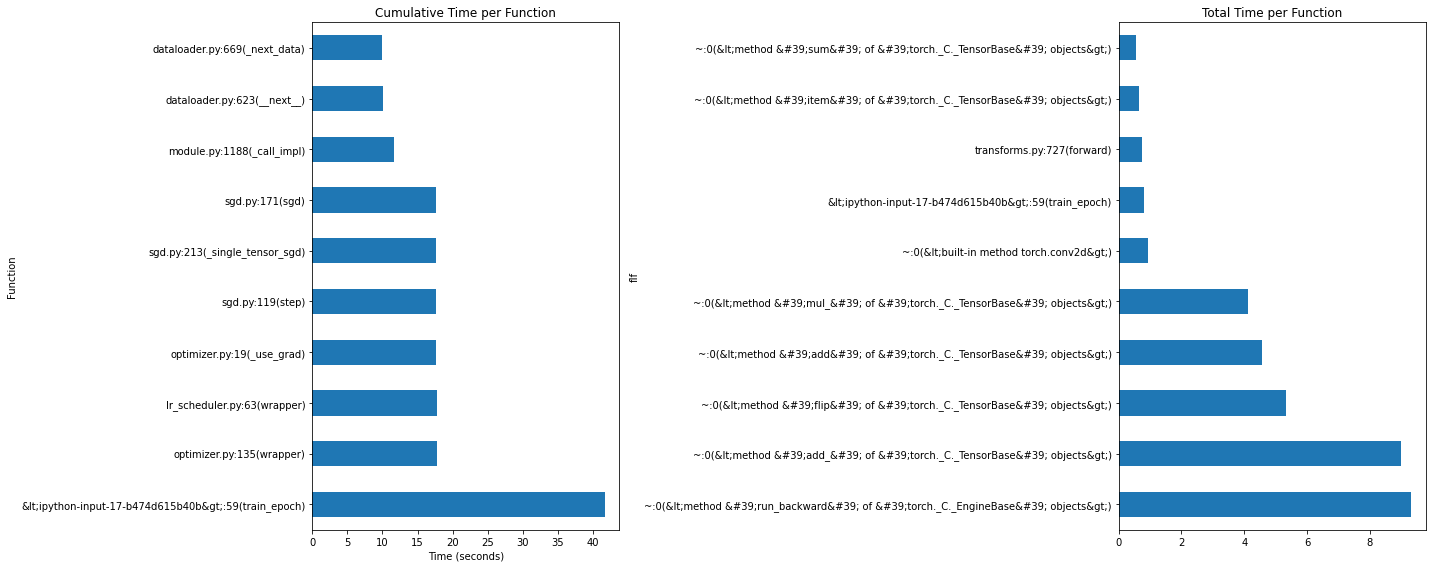

End of testing. Test accuracy 9.99%
Epoch 1
Train (step: 10/391)- (avg) loss: 4.4456 (avg) acc: 12.64%
Train (step: 110/391)- (avg) loss: 2.7723 (avg) acc: 13.97%
Train (step: 210/391)- (avg) loss: 2.5385 (avg) acc: 16.44%
Train (step: 310/391)- (avg) loss: 2.4113 (avg) acc: 18.19%


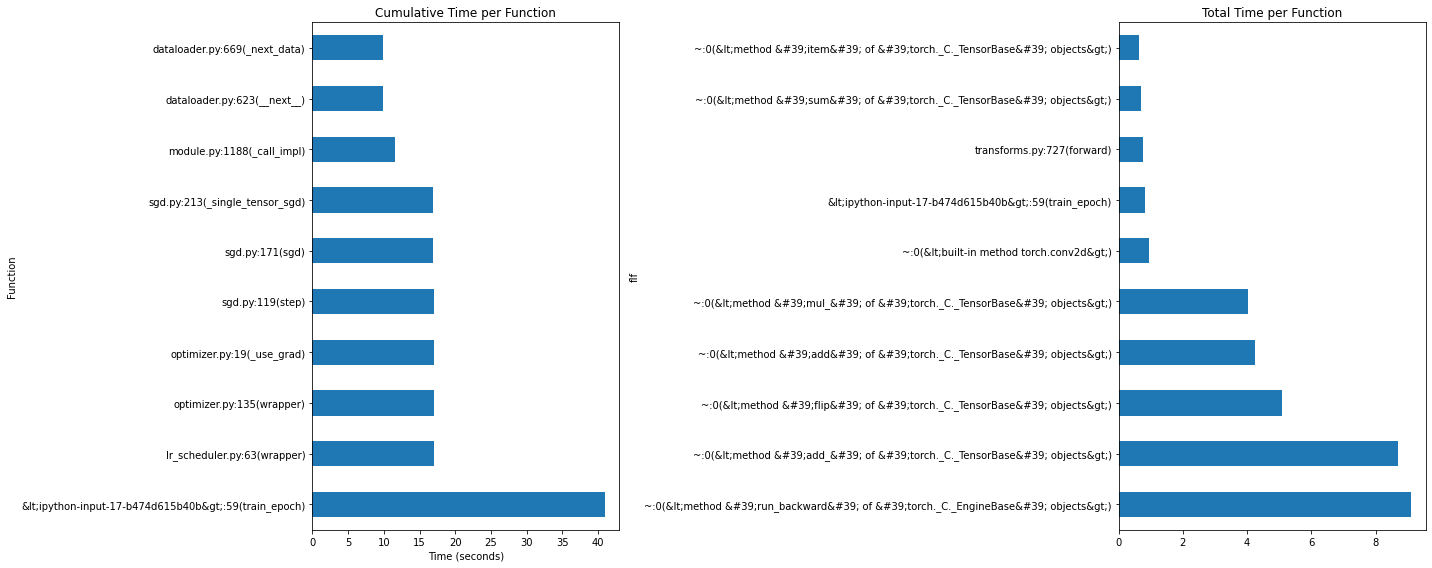

End of testing. Test accuracy 22.72%
Epoch 2
Train (step: 10/391)- (avg) loss: 2.1712 (avg) acc: 26.07%
Train (step: 110/391)- (avg) loss: 2.2089 (avg) acc: 25.29%
Train (step: 210/391)- (avg) loss: 2.0403 (avg) acc: 27.15%


KeyboardInterrupt: ignored

In [ ]:
train_test(net, criterion, optimizer, scheduler, transformed_dataset["train"], transformed_dataset["eval"], NUM_EPOCHS, BATCHSIZE, num_workers=0)

In [ ]:
net = DawnNet().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = SGDOptimizer(net.parameters(), weight_decay=5e-4*(BATCHSIZE := 512))
scheduler = PiecewiseLinearScheduler(optimizer, EPOCHS:=[0, 15, 30, NUM_EPOCHS:=35], LR:=[0, 0.44, 0.005, 0])

Epoch 0
Train (step: 10/98)- (avg) loss: 2.6475 (avg) acc: 10.67%


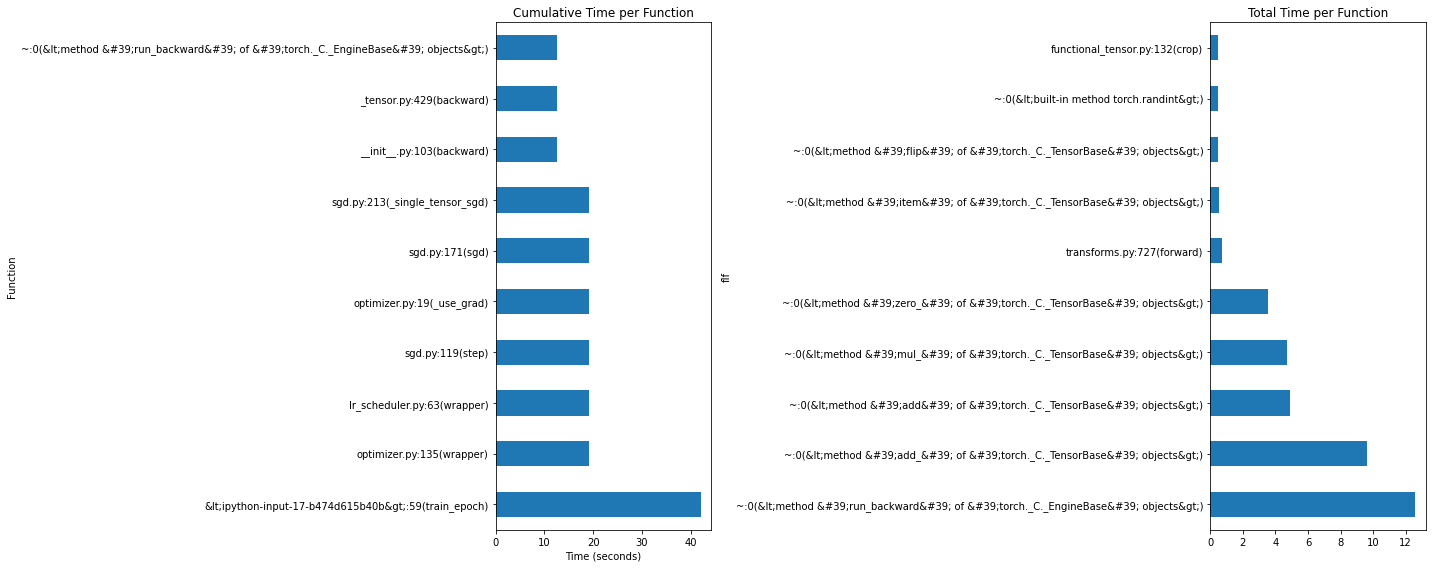

End of testing. Test accuracy 10.80%
Epoch 1
Train (step: 10/98)- (avg) loss: 6.2252 (avg) acc: 10.33%


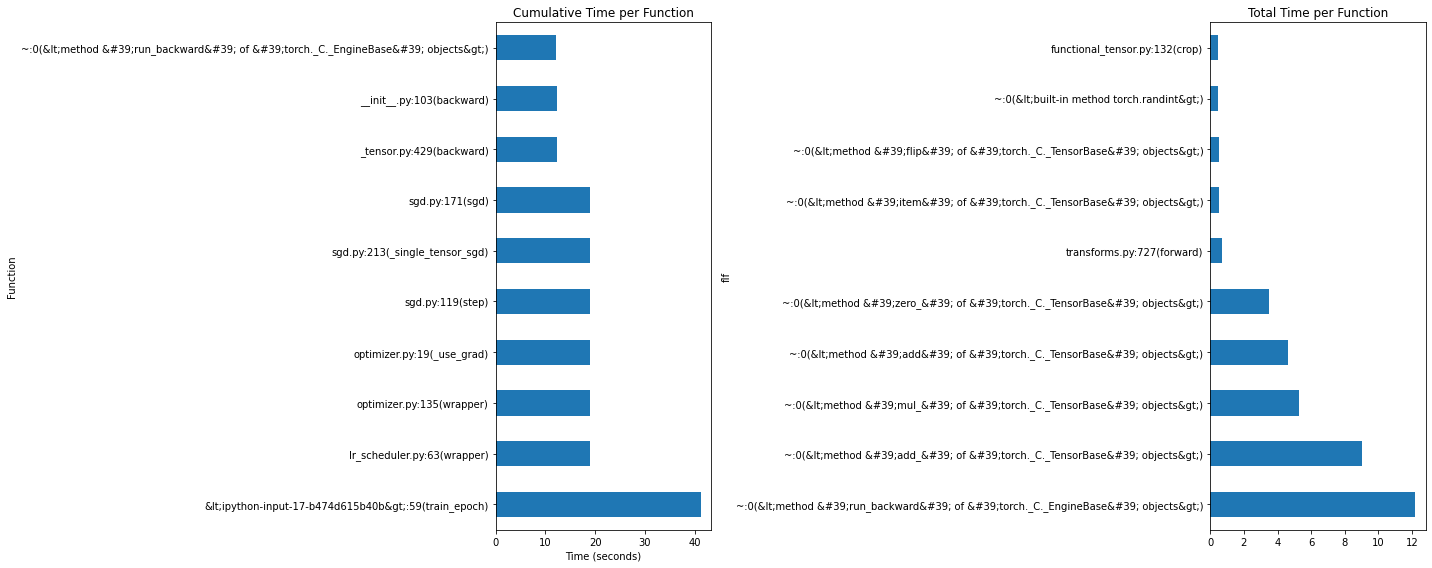

End of testing. Test accuracy 11.40%
Epoch 2
Train (step: 10/98)- (avg) loss: 2.3298 (avg) acc: 10.88%


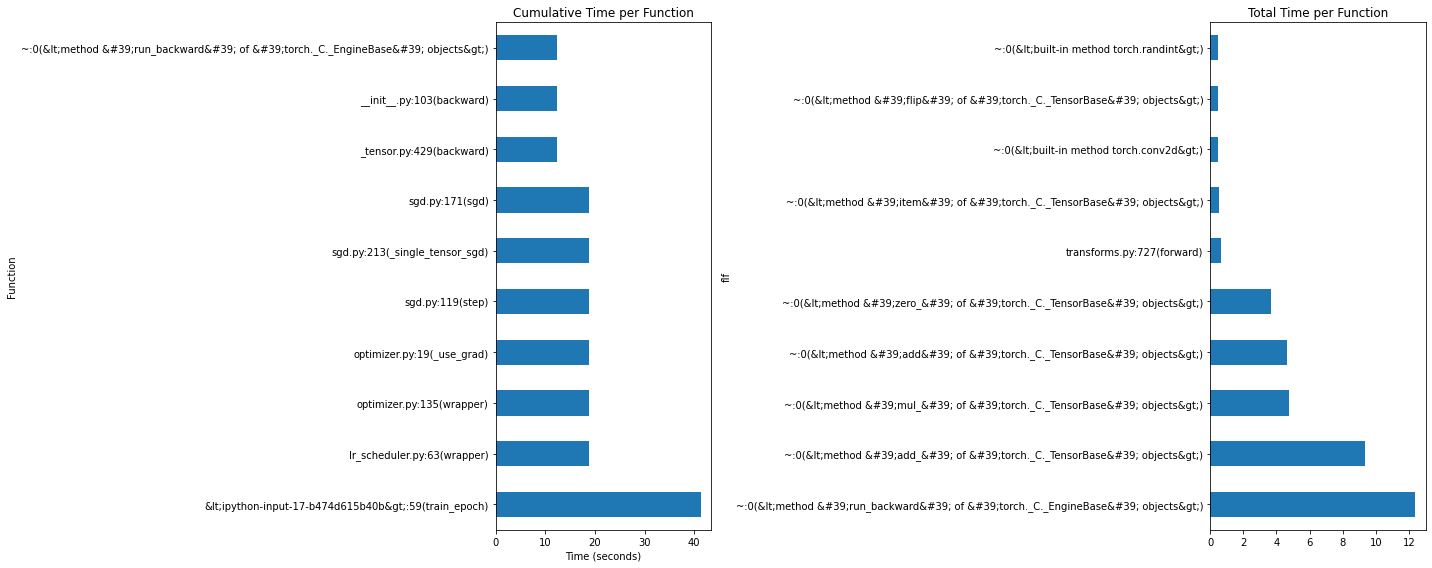

End of testing. Test accuracy 15.97%
Epoch 3
Train (step: 10/98)- (avg) loss: 2.2286 (avg) acc: 15.59%


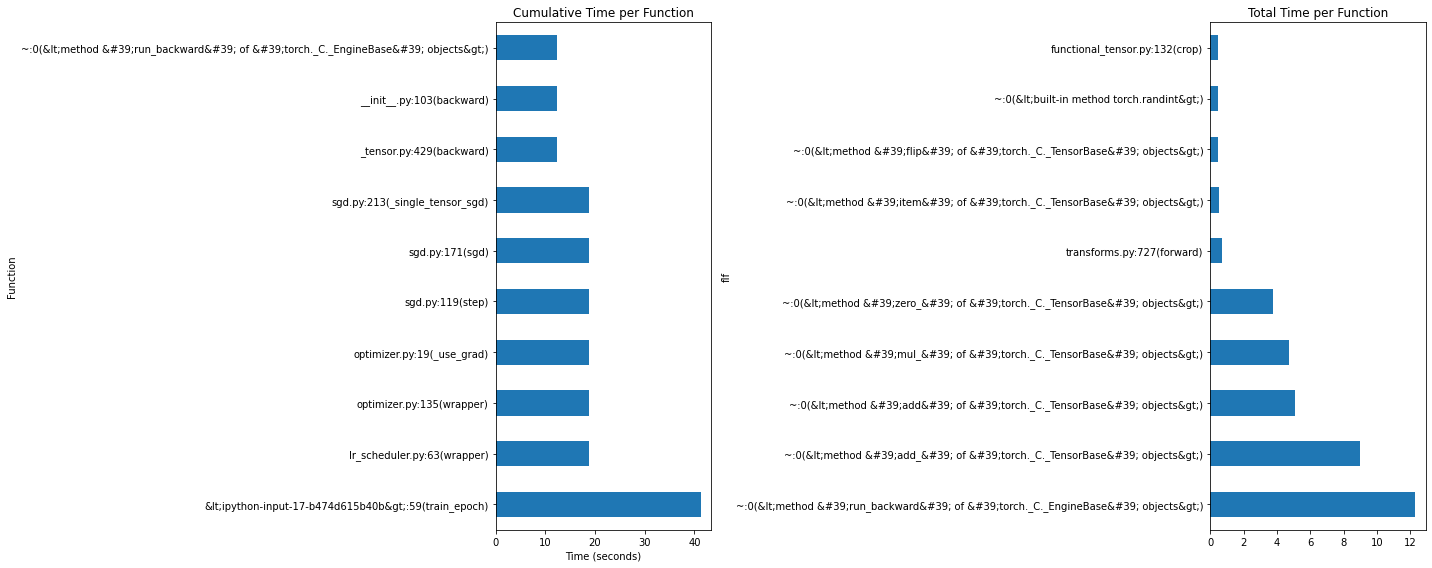

End of testing. Test accuracy 22.71%
Epoch 4
Train (step: 10/98)- (avg) loss: 2.0090 (avg) acc: 22.50%
End of testing. Test accuracy 27.88%
Epoch 5
Train (step: 10/98)- (avg) loss: 1.8194 (avg) acc: 29.90%


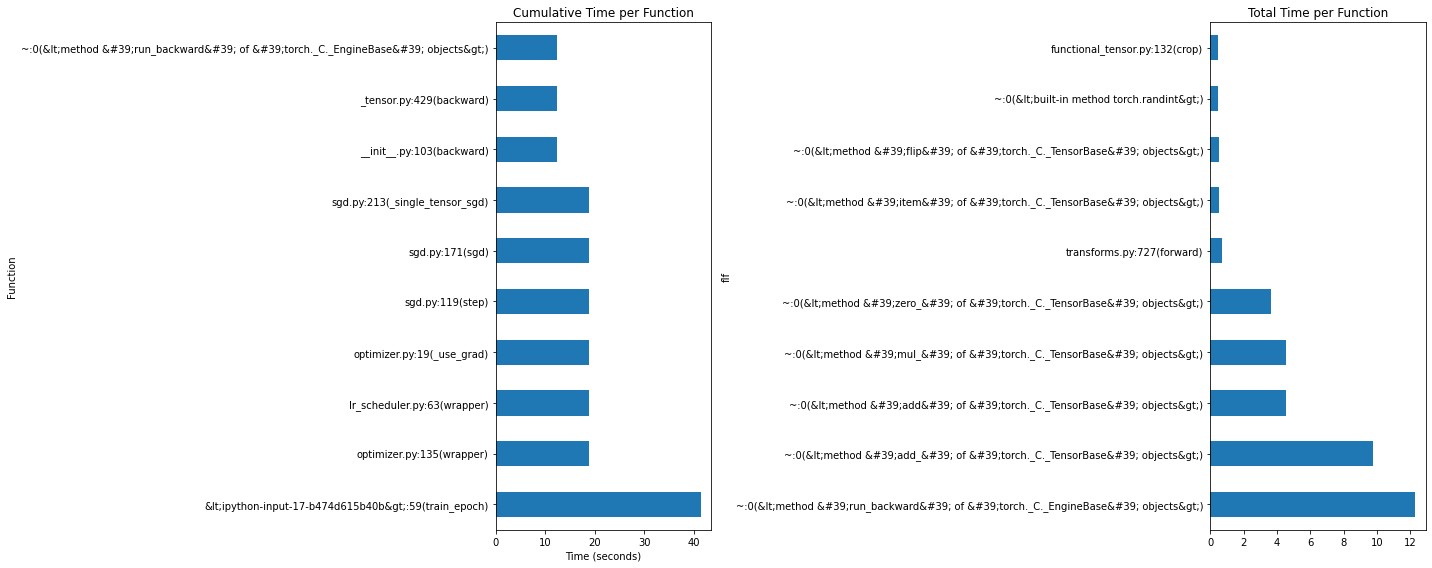

End of testing. Test accuracy 38.27%
Epoch 6
Train (step: 10/98)- (avg) loss: 1.7025 (avg) acc: 35.00%


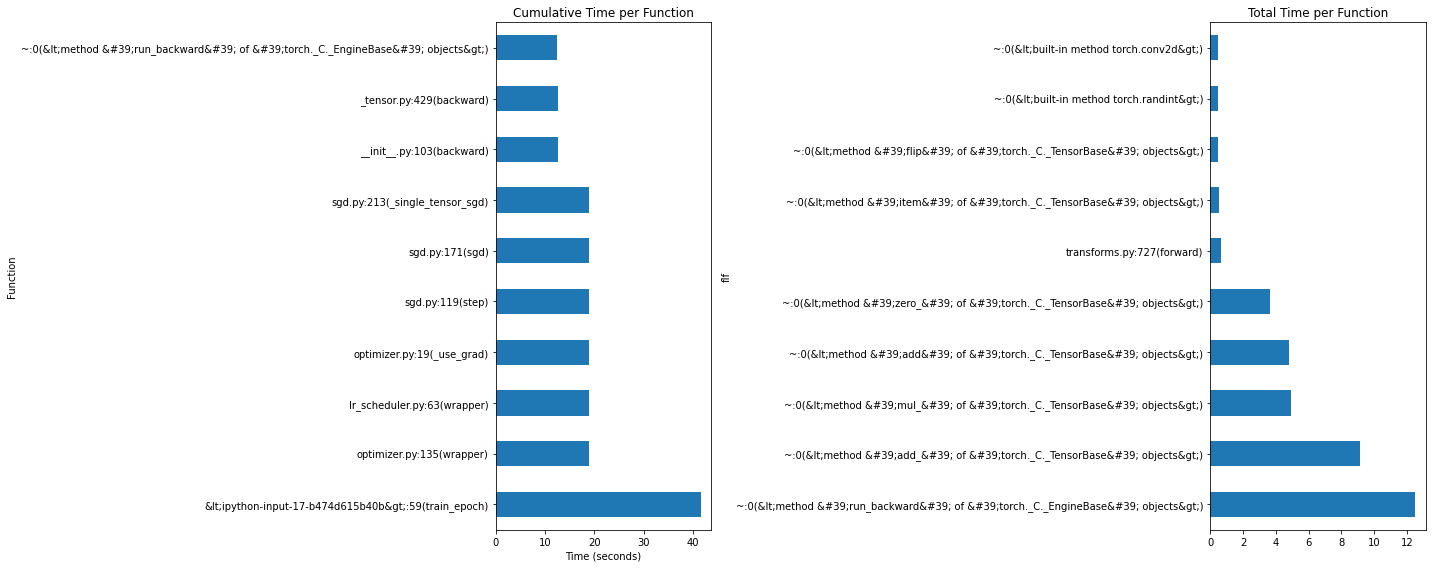

End of testing. Test accuracy 42.49%
Epoch 7
Train (step: 10/98)- (avg) loss: 1.5179 (avg) acc: 43.45%


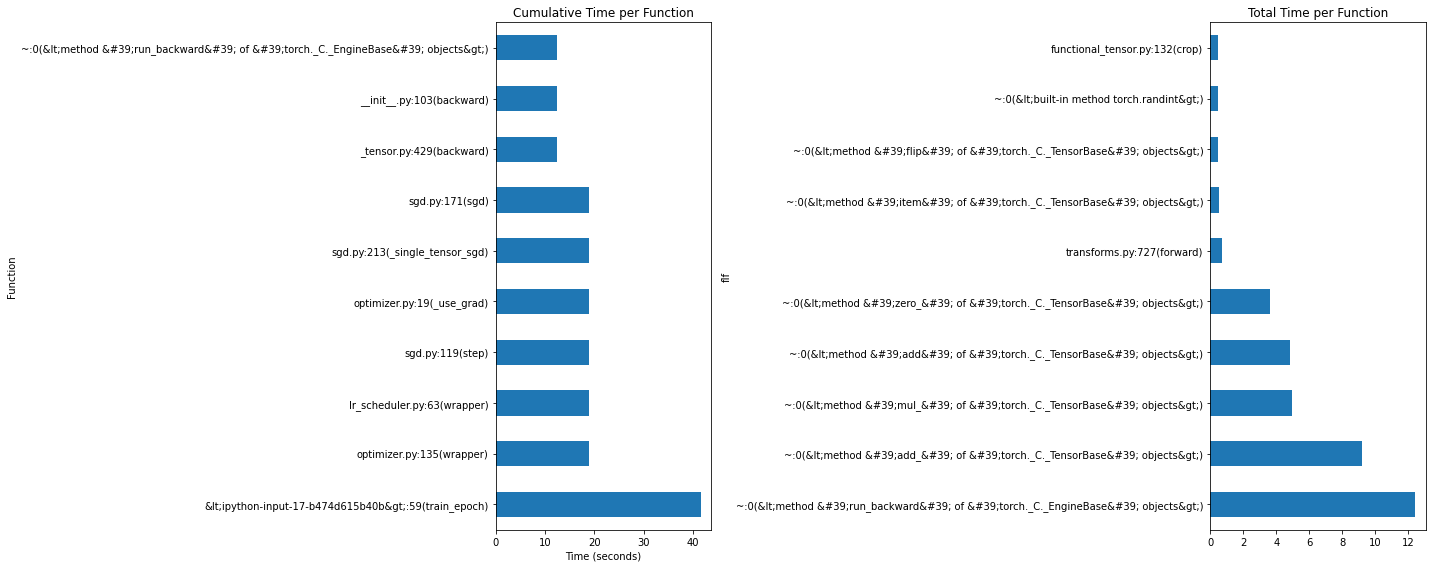

End of testing. Test accuracy 48.33%
Epoch 8
Train (step: 10/98)- (avg) loss: 1.3169 (avg) acc: 51.24%


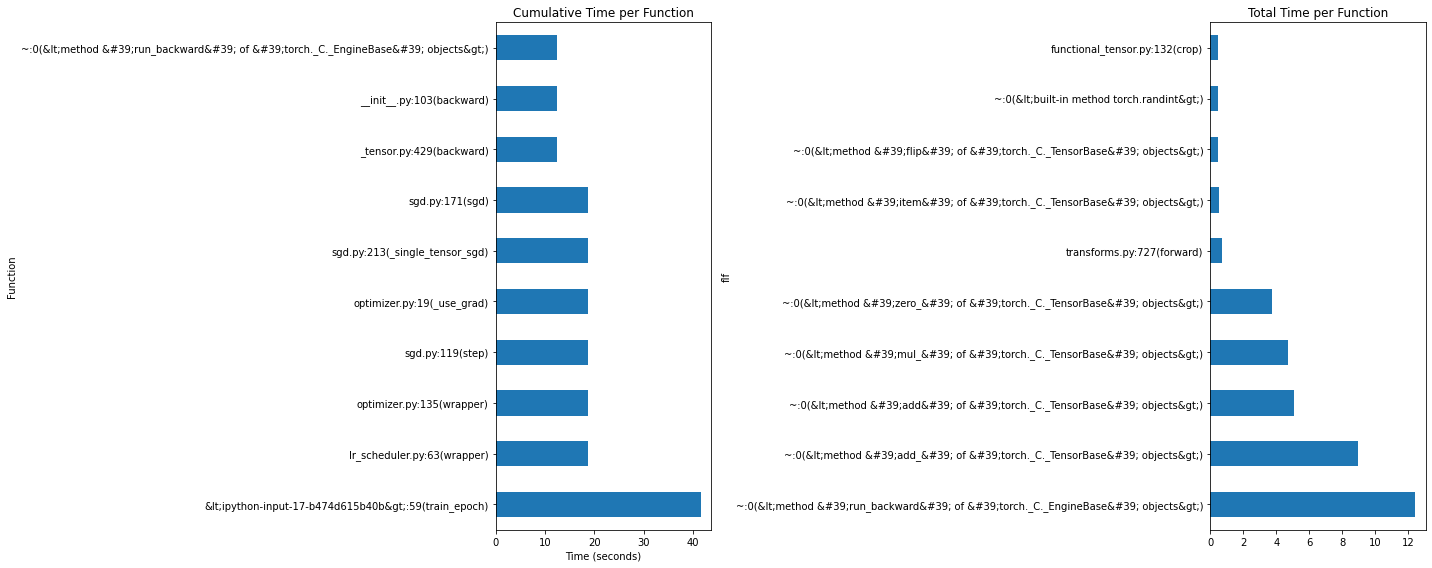

End of testing. Test accuracy 51.95%
Epoch 9
Train (step: 10/98)- (avg) loss: 1.1747 (avg) acc: 57.87%


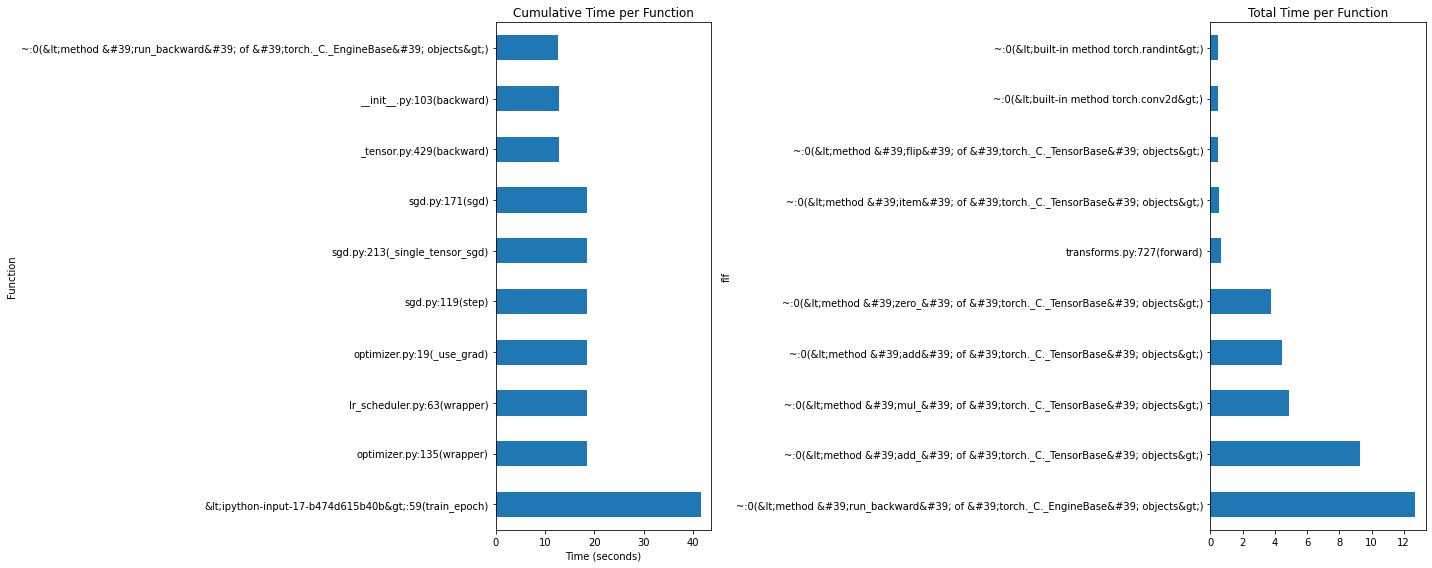

End of testing. Test accuracy 54.66%
Epoch 10
Train (step: 10/98)- (avg) loss: 1.0340 (avg) acc: 62.46%


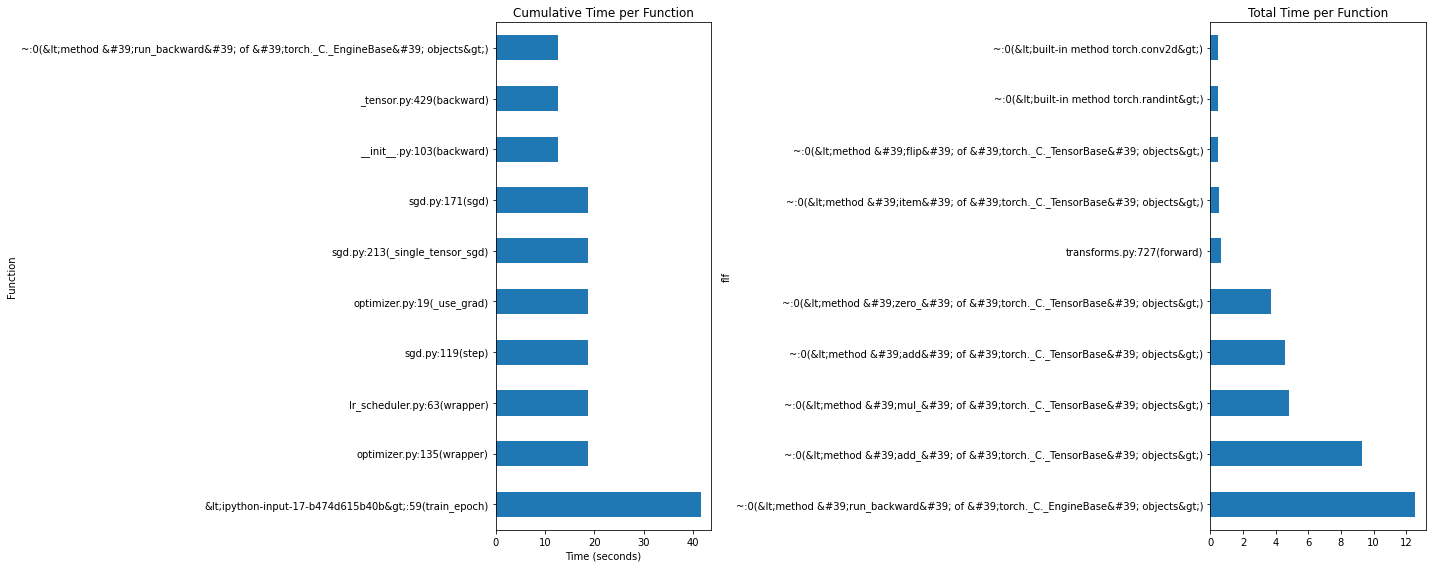

End of testing. Test accuracy 53.42%
Epoch 11
Train (step: 10/98)- (avg) loss: 0.9452 (avg) acc: 66.23%


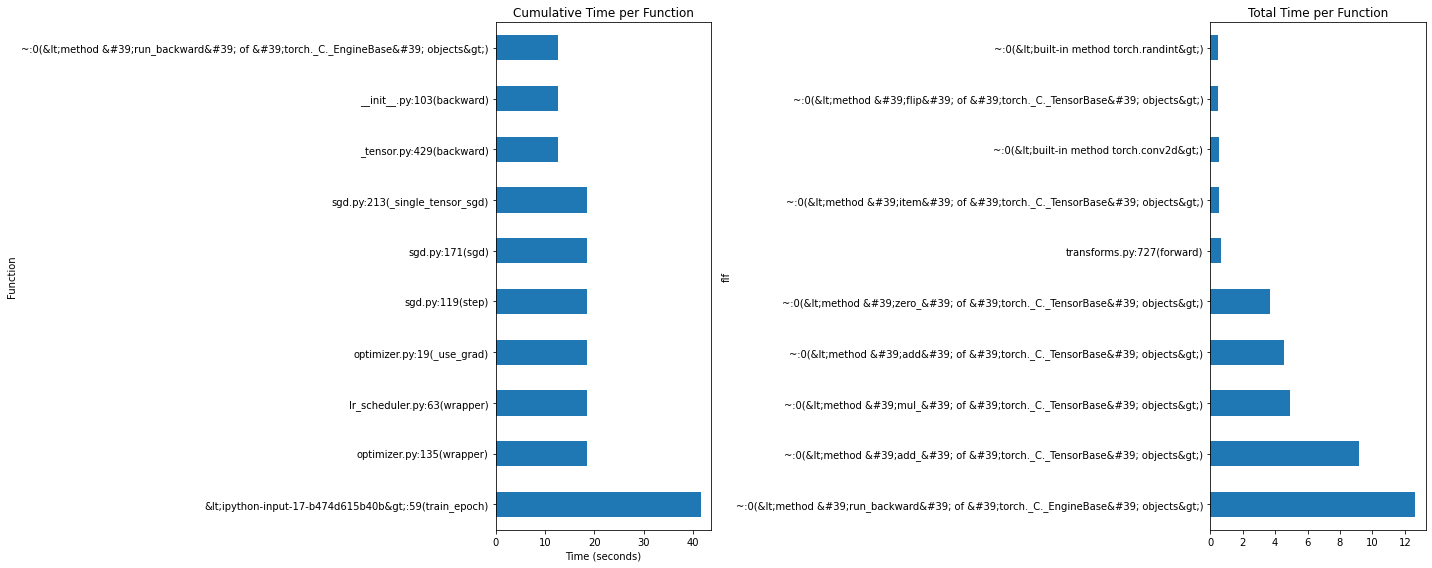

End of testing. Test accuracy 60.78%
Epoch 12
Train (step: 10/98)- (avg) loss: 0.8448 (avg) acc: 68.98%


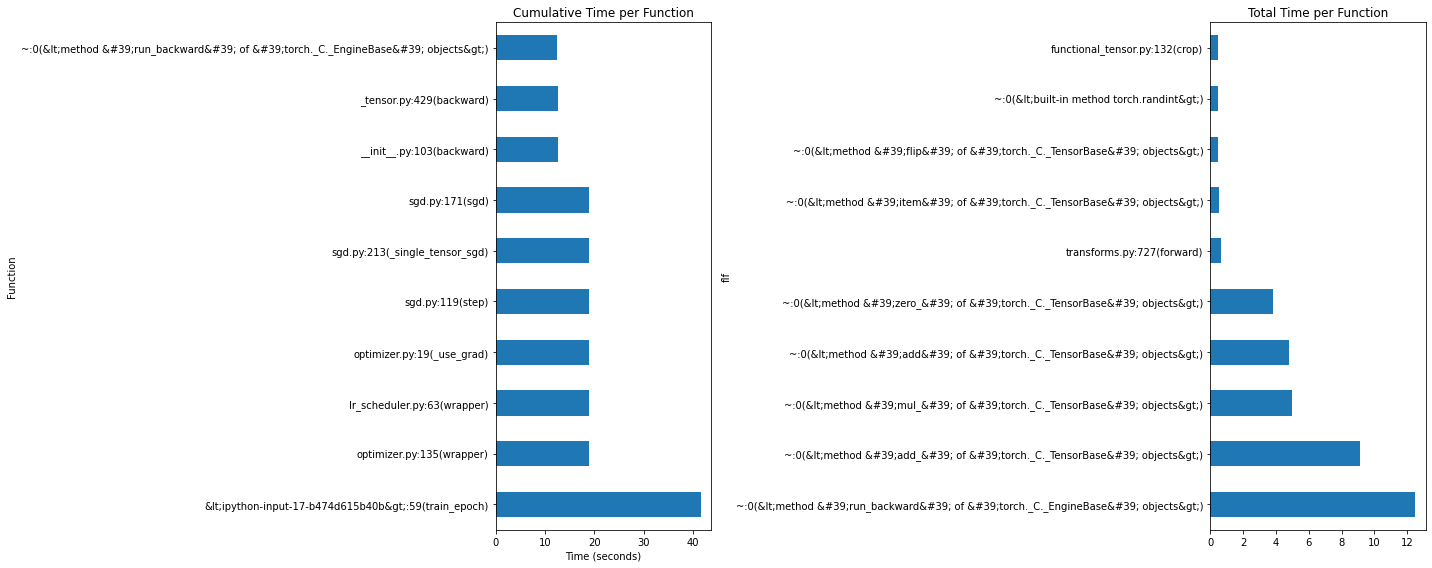

End of testing. Test accuracy 64.24%
Epoch 13


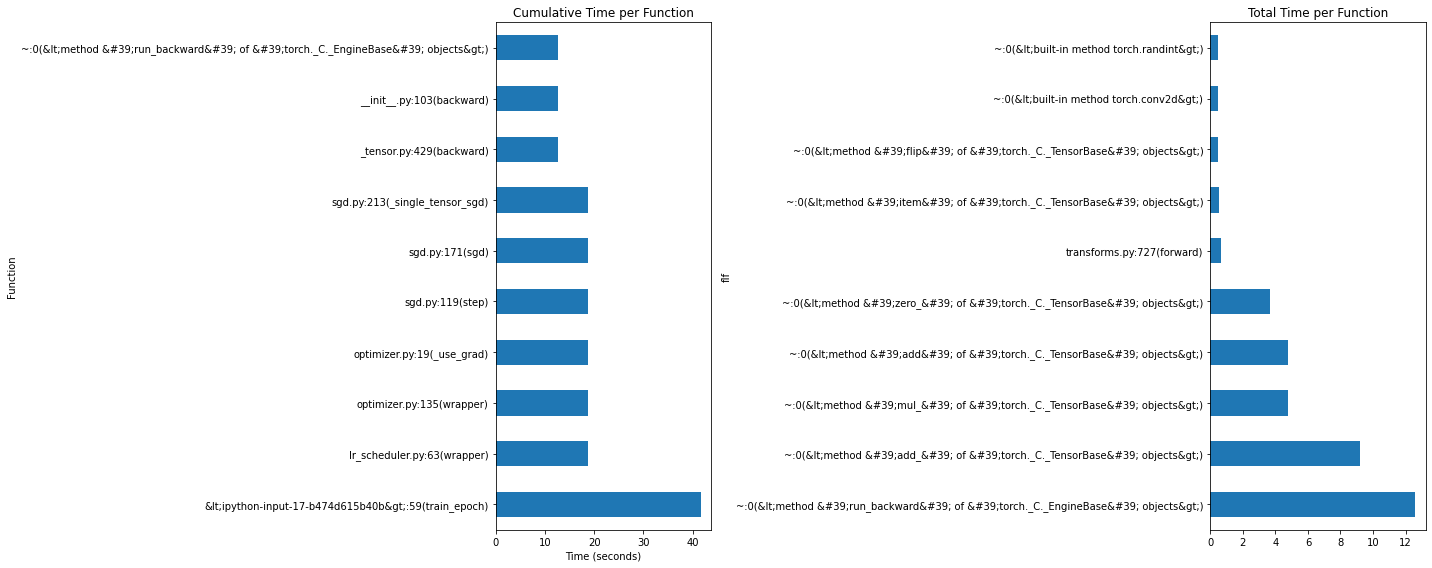

End of testing. Test accuracy 66.71%
Epoch 14
Train (step: 10/98)- (avg) loss: 0.7236 (avg) acc: 74.45%


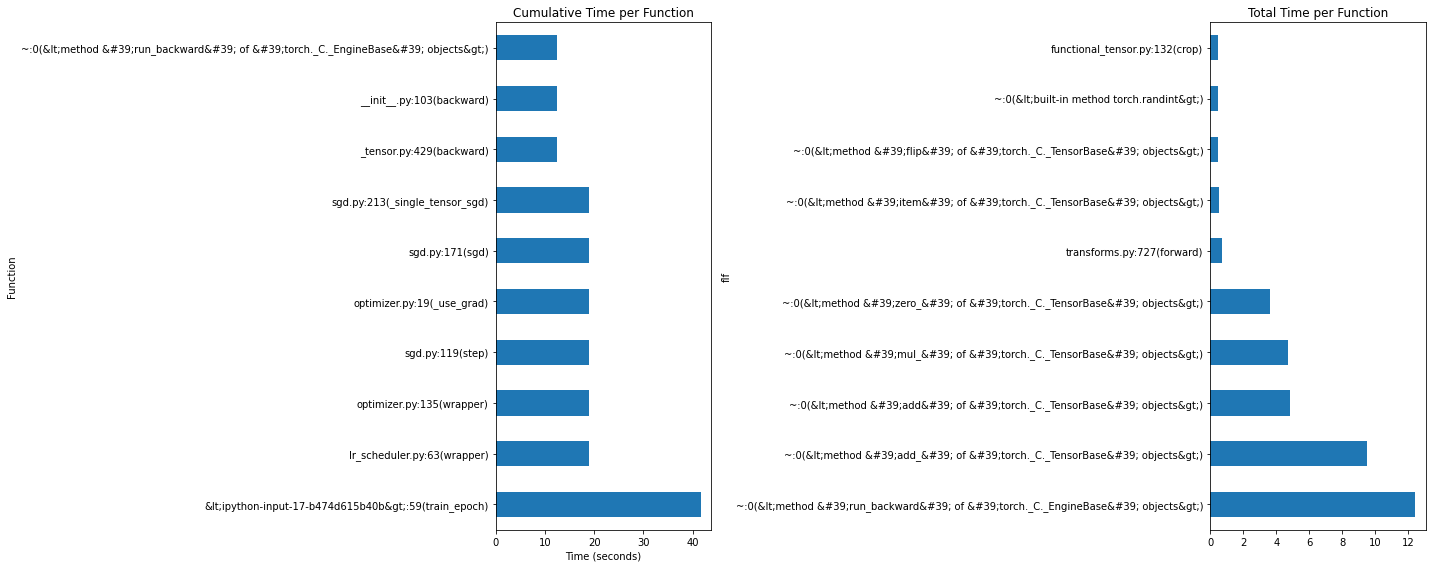

End of testing. Test accuracy 70.89%
Epoch 15
Train (step: 10/98)- (avg) loss: 0.6882 (avg) acc: 75.39%


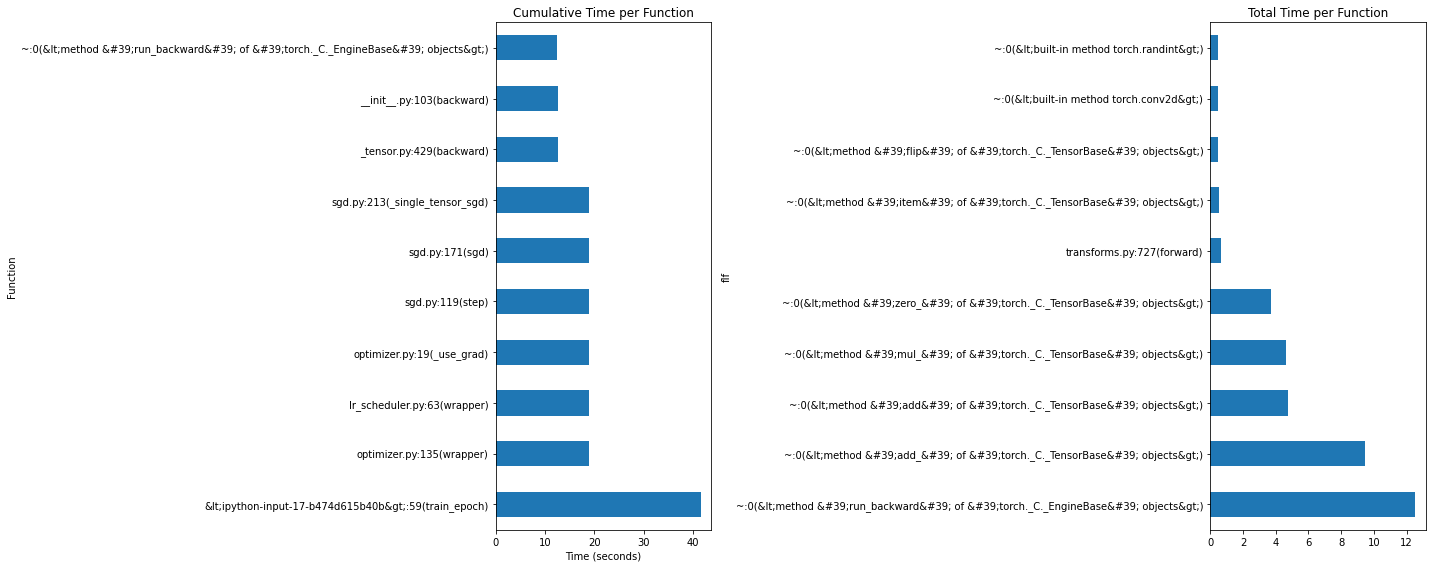

End of testing. Test accuracy 66.19%
Epoch 16
Train (step: 10/98)- (avg) loss: 0.6312 (avg) acc: 77.79%


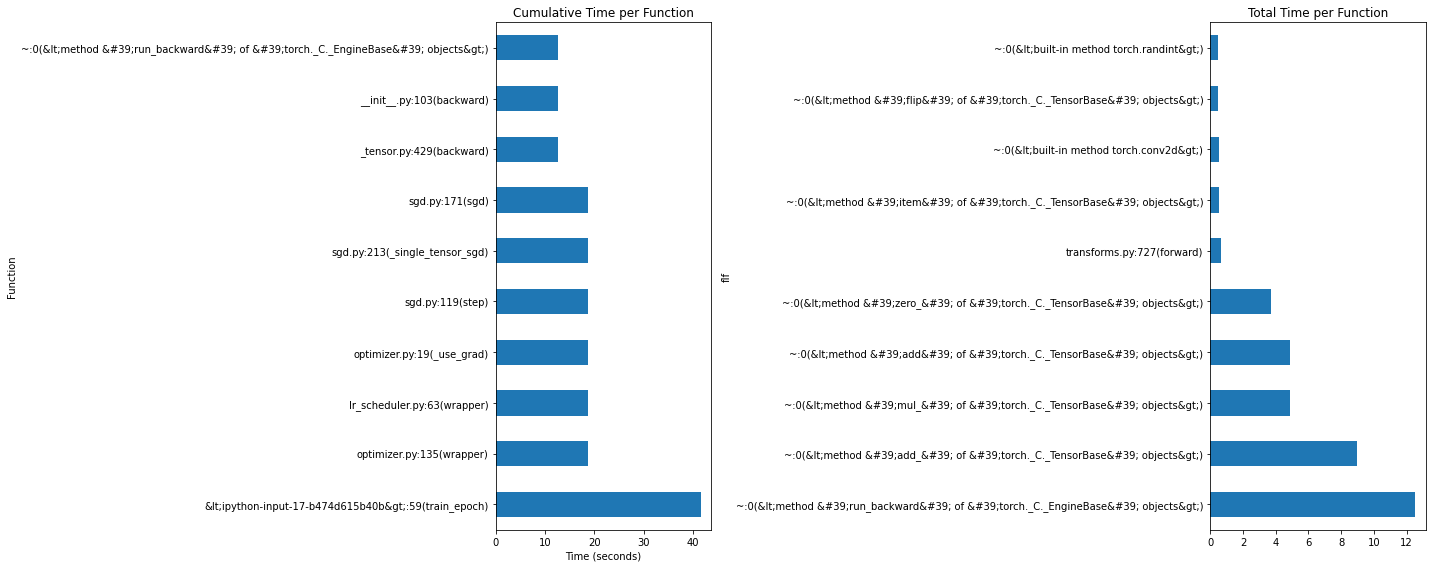

End of testing. Test accuracy 70.45%
Epoch 17
Train (step: 10/98)- (avg) loss: 0.5749 (avg) acc: 79.28%


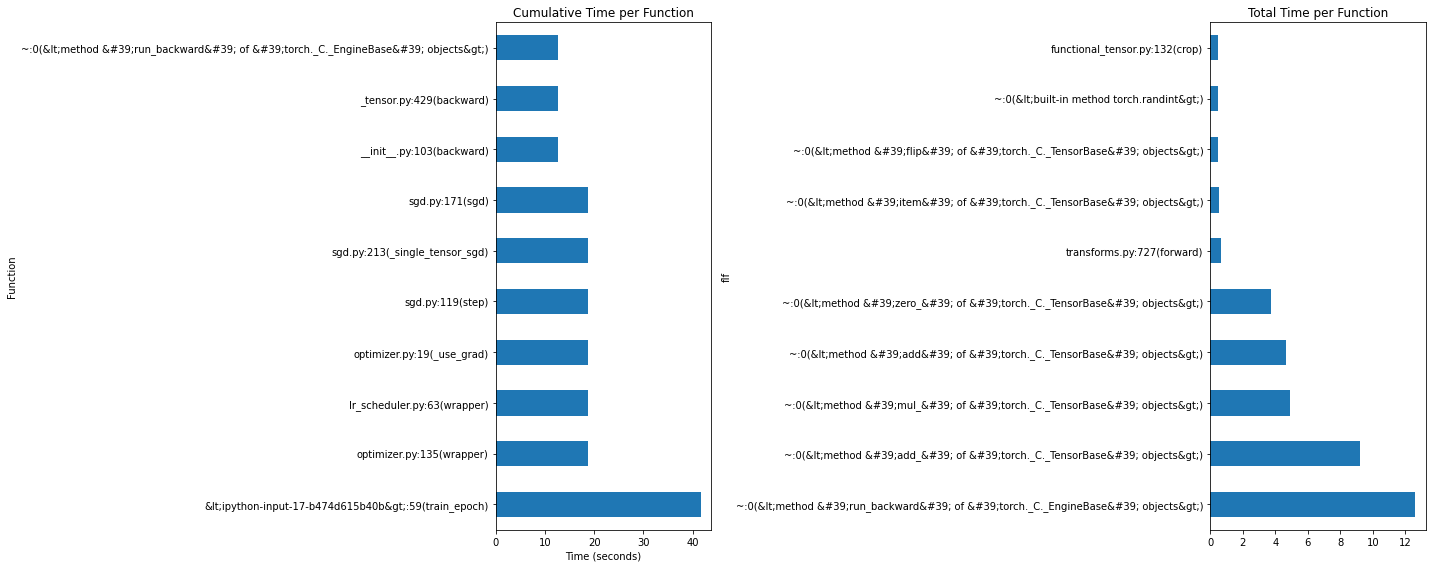

End of testing. Test accuracy 76.91%
Epoch 18
Train (step: 10/98)- (avg) loss: 0.4856 (avg) acc: 82.94%


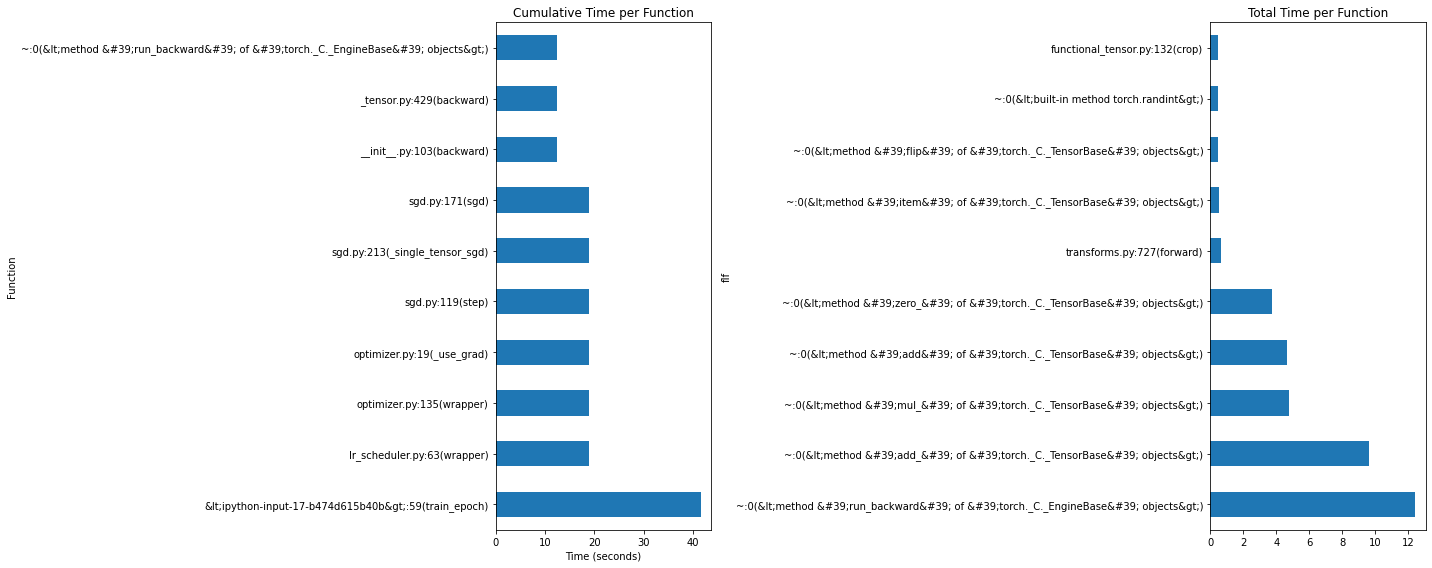

End of testing. Test accuracy 73.58%
Epoch 19
Train (step: 10/98)- (avg) loss: 0.4484 (avg) acc: 83.91%


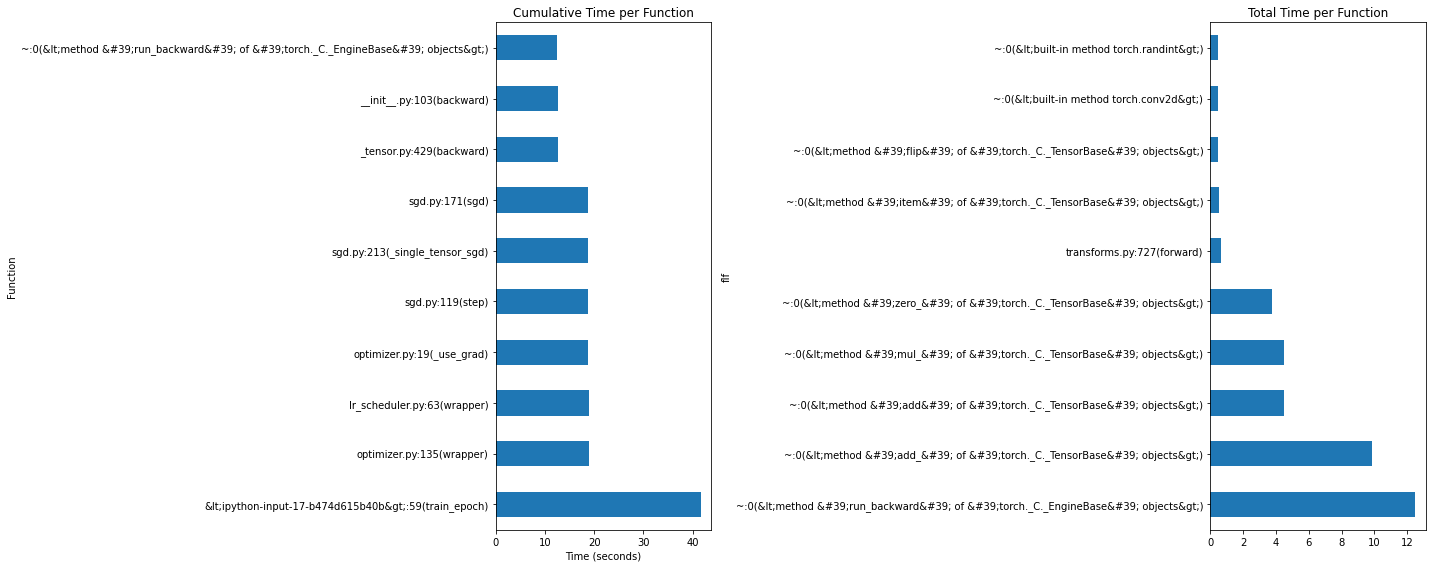

End of testing. Test accuracy 76.50%
Epoch 20
Train (step: 10/98)- (avg) loss: 0.4133 (avg) acc: 85.09%


KeyboardInterrupt: ignored

In [ ]:
train_test(net, criterion, optimizer, scheduler, transformed_dataset["train"], transformed_dataset["eval"], NUM_EPOCHS, BATCHSIZE, num_workers=0)

Epoch 0
Train (step: 10/98)- (avg) loss: 2.6491 (avg) acc: 10.40%


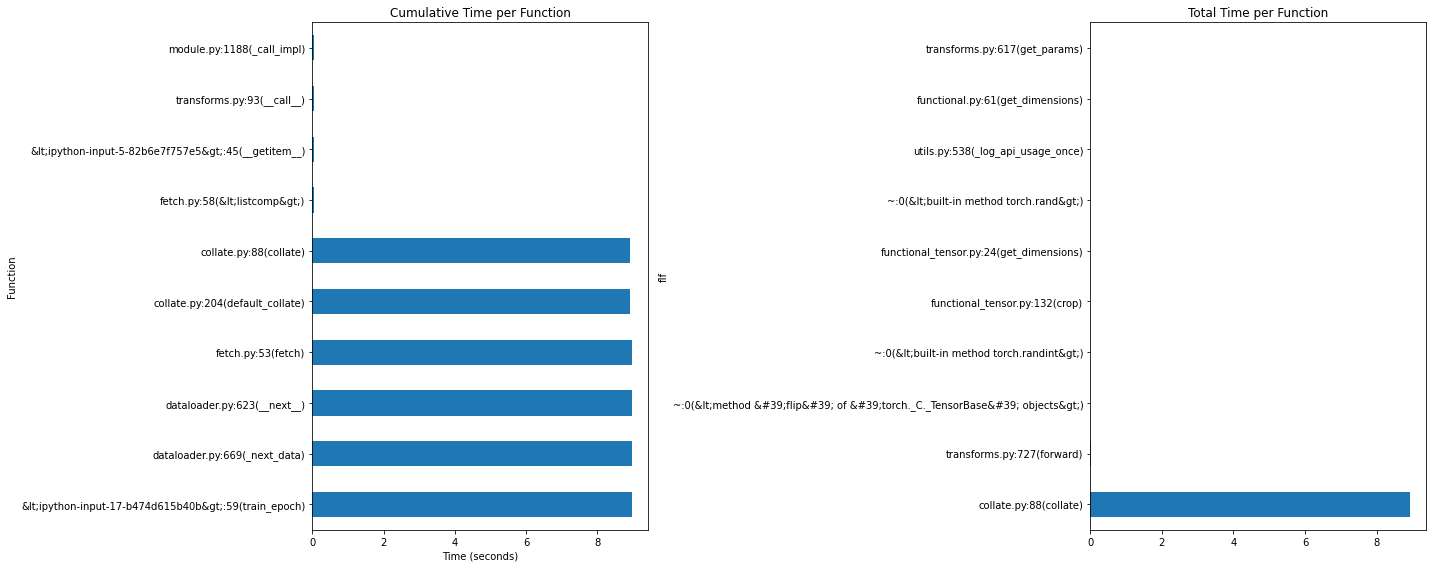

End of testing. Test accuracy 10.39%
Epoch 1
Train (step: 10/98)- (avg) loss: 19.7772 (avg) acc: 10.87%


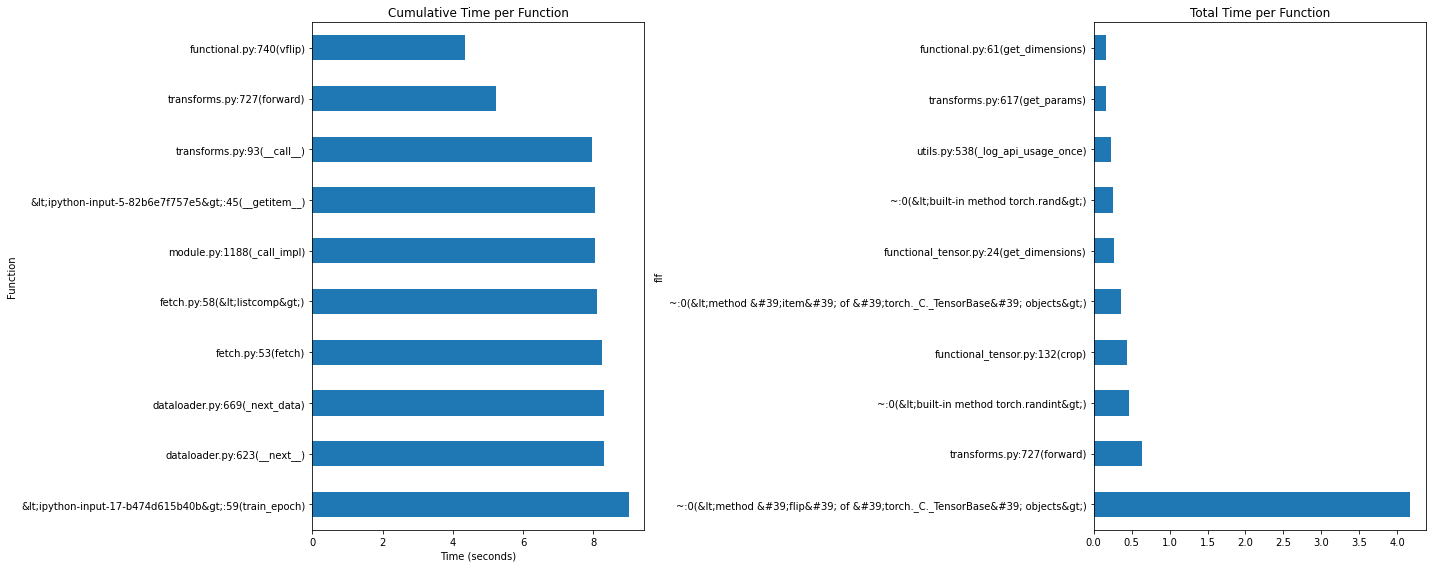

End of testing. Test accuracy 11.46%
Epoch 2
Train (step: 10/98)- (avg) loss: 2.2914 (avg) acc: 11.40%


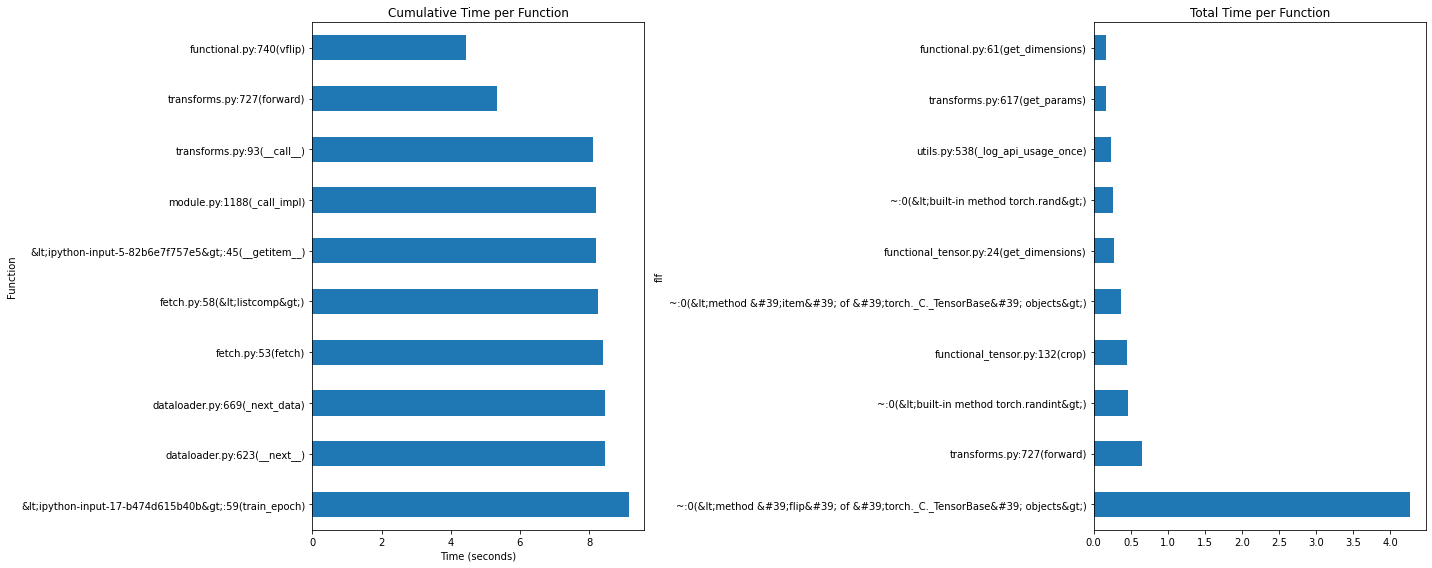

End of testing. Test accuracy 13.65%
Epoch 3
Train (step: 10/98)- (avg) loss: 2.2772 (avg) acc: 13.87%


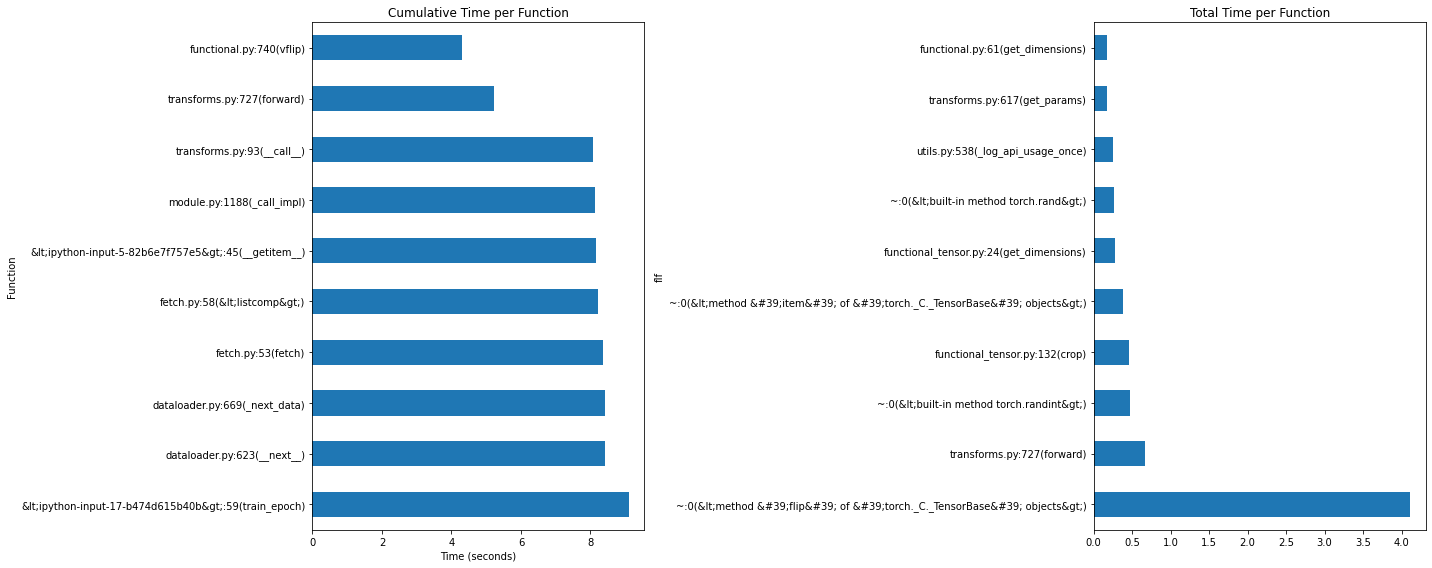

End of testing. Test accuracy 19.16%
Epoch 4
Train (step: 10/98)- (avg) loss: 2.0813 (avg) acc: 19.42%


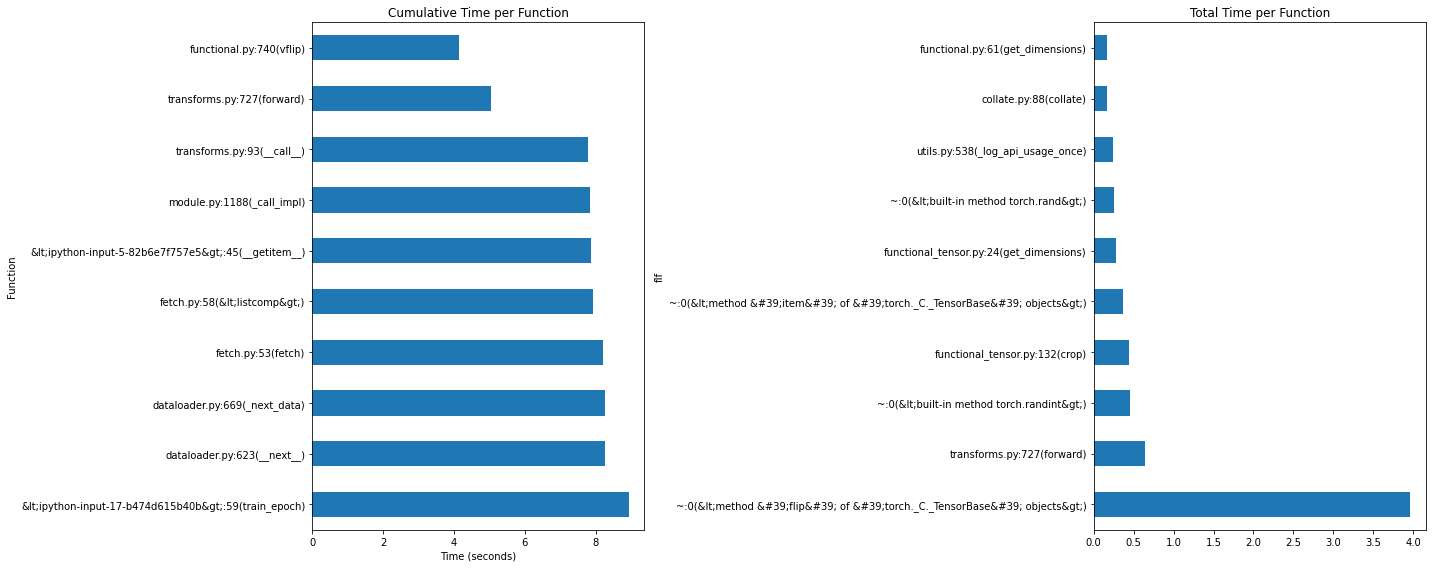

End of testing. Test accuracy 19.10%
Epoch 5
Train (step: 10/98)- (avg) loss: 2.0096 (avg) acc: 19.92%


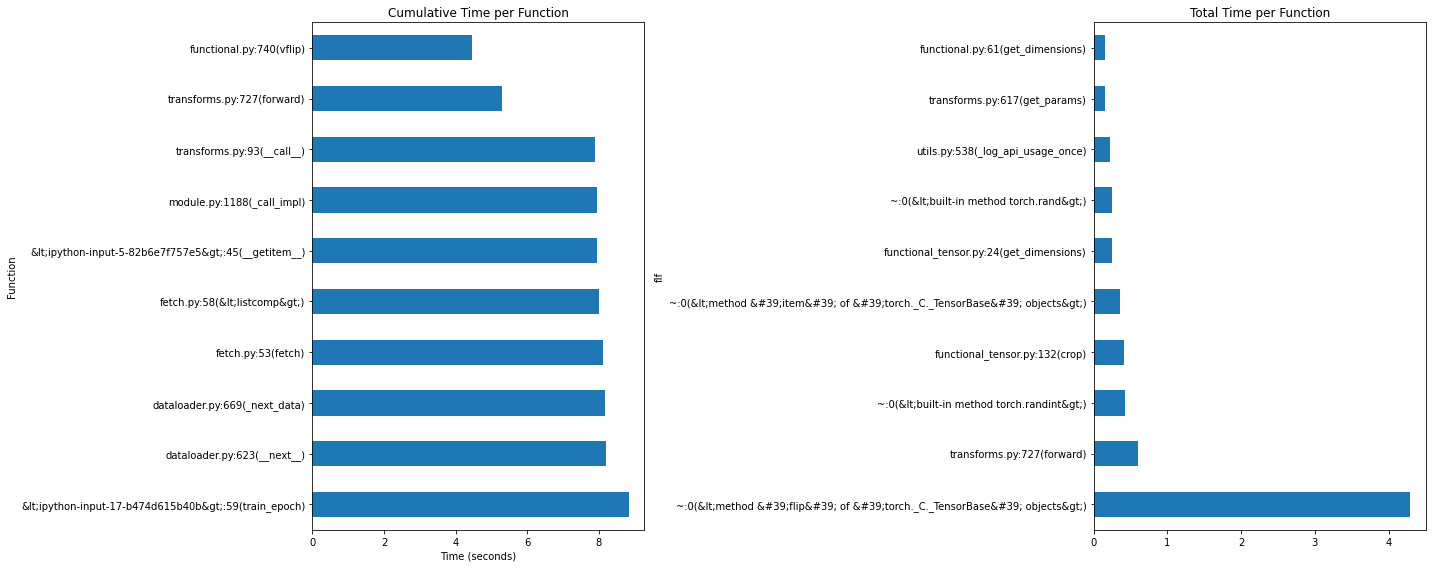

End of testing. Test accuracy 21.66%
Epoch 6
Train (step: 10/98)- (avg) loss: 1.8933 (avg) acc: 24.86%


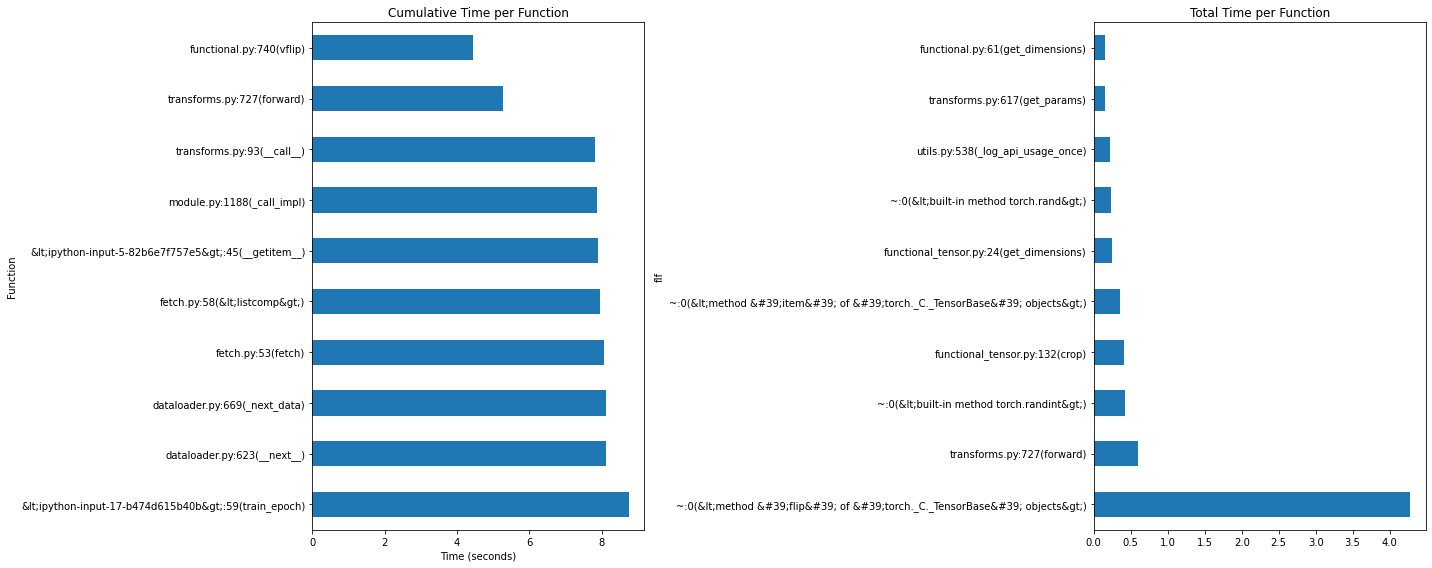

End of testing. Test accuracy 26.69%
Epoch 7
Train (step: 10/98)- (avg) loss: 1.8001 (avg) acc: 28.27%


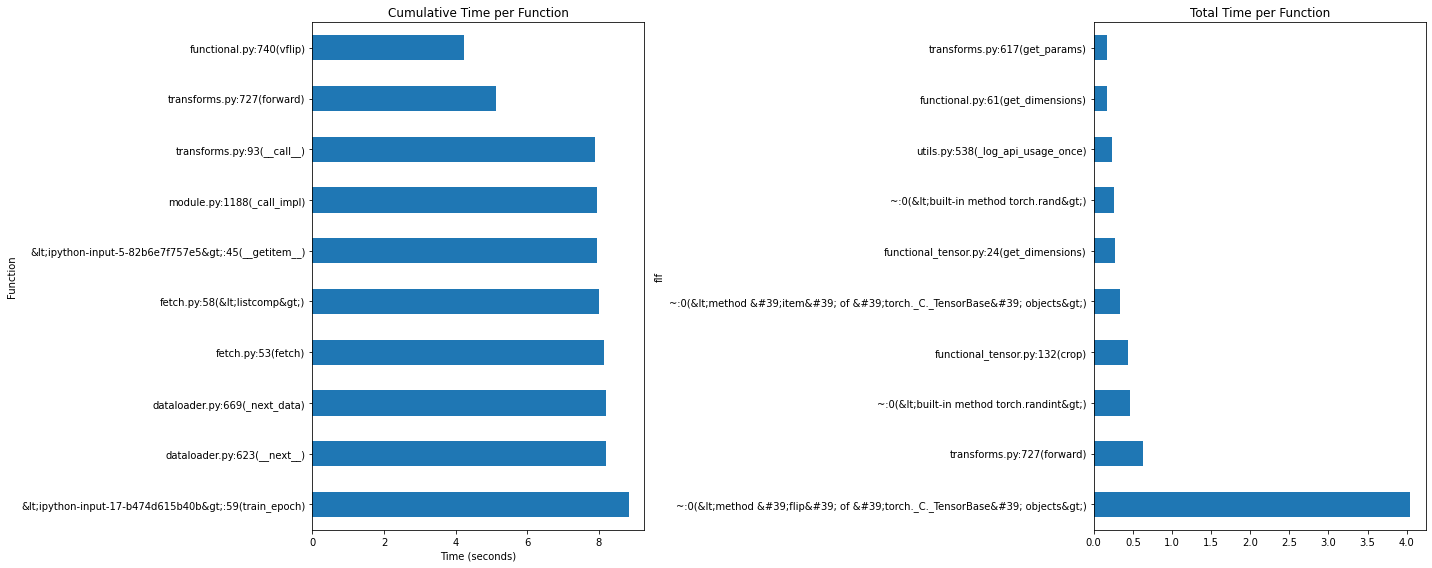

End of testing. Test accuracy 28.76%
Epoch 8
Train (step: 10/98)- (avg) loss: 1.7794 (avg) acc: 30.45%


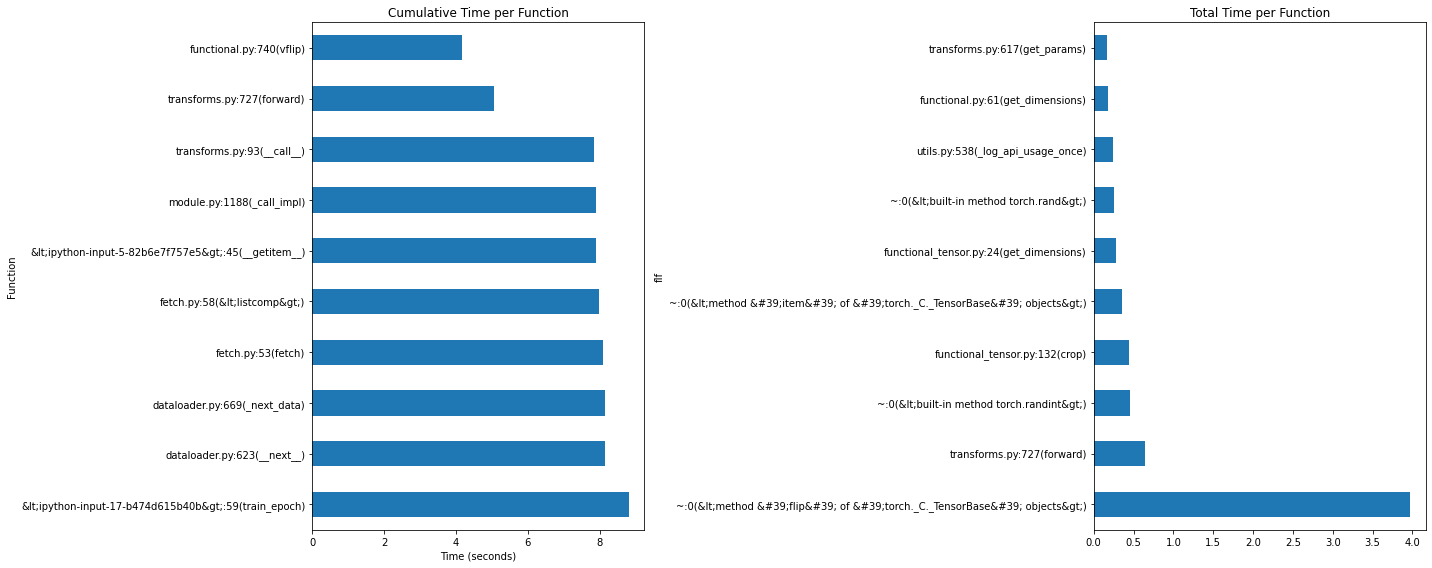

End of testing. Test accuracy 30.43%
Epoch 9
Train (step: 10/98)- (avg) loss: 1.7390 (avg) acc: 32.37%


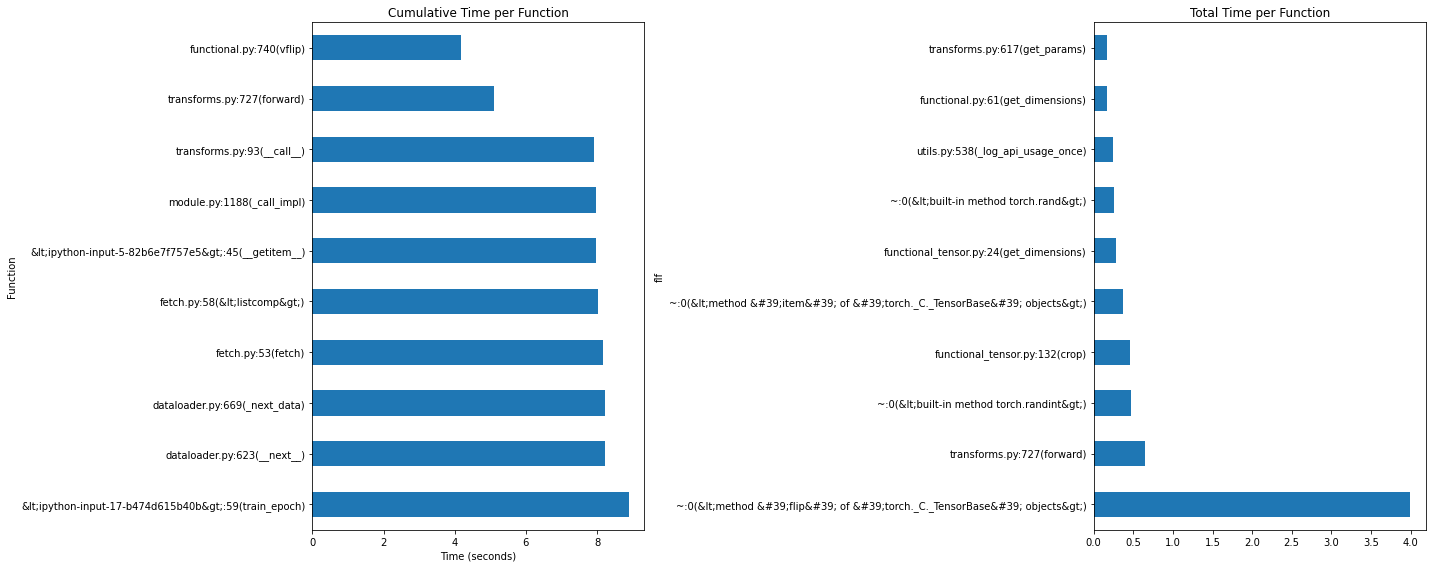

End of testing. Test accuracy 30.34%
Epoch 10
Train (step: 10/98)- (avg) loss: 1.7097 (avg) acc: 32.90%


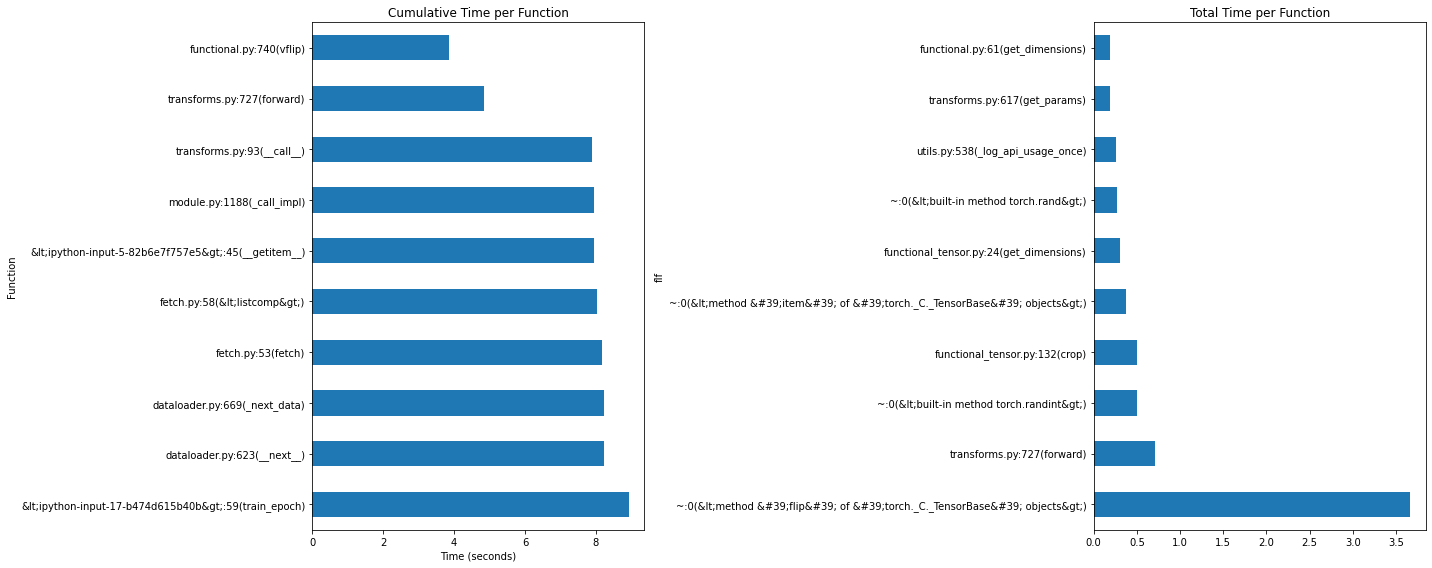

End of testing. Test accuracy 33.08%
Epoch 11
Train (step: 10/98)- (avg) loss: 1.6622 (avg) acc: 35.44%
End of testing. Test accuracy 32.67%
Epoch 12
Train (step: 10/98)- (avg) loss: 1.6546 (avg) acc: 35.16%


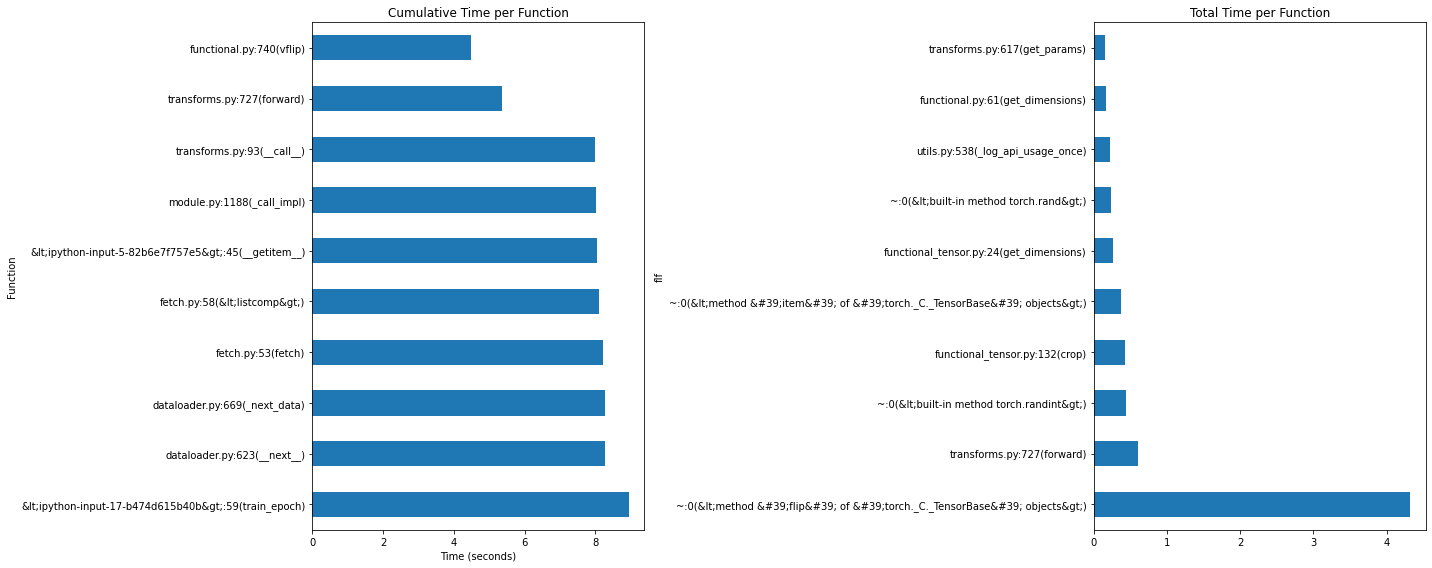

End of testing. Test accuracy 35.33%
Epoch 13
Train (step: 10/98)- (avg) loss: 1.6596 (avg) acc: 36.40%


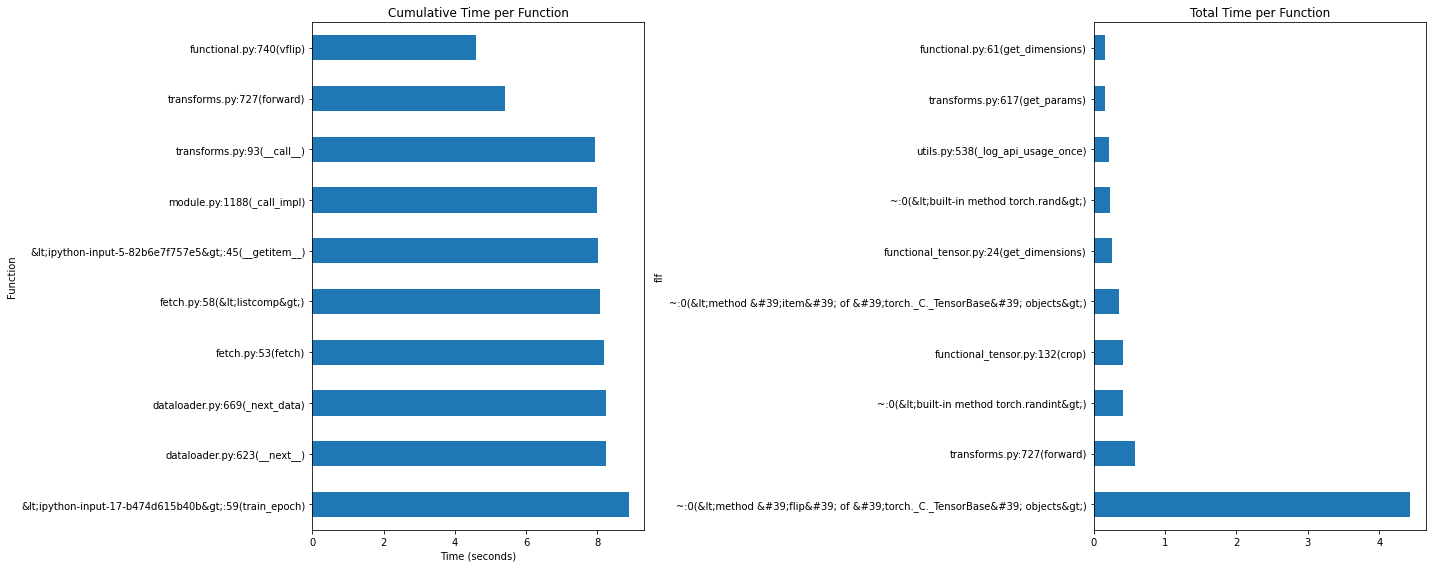

End of testing. Test accuracy 33.83%
Epoch 14
Train (step: 10/98)- (avg) loss: 1.6128 (avg) acc: 36.58%


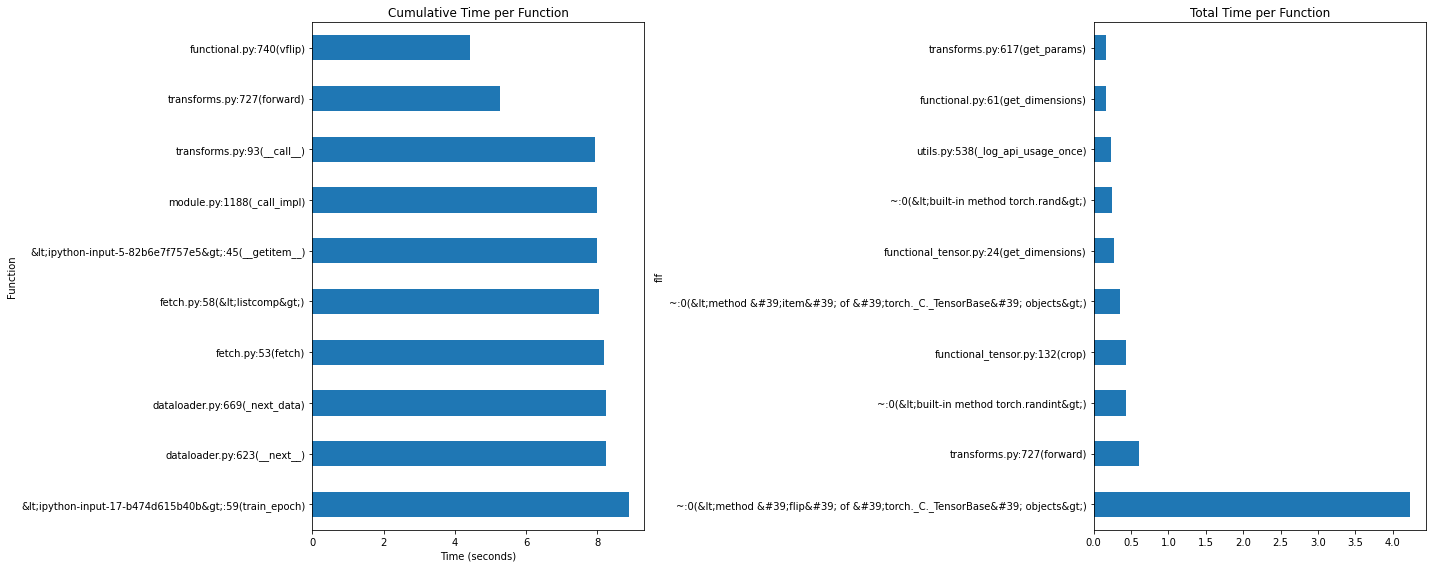

End of testing. Test accuracy 36.15%
Epoch 15
Train (step: 10/98)- (avg) loss: 1.6040 (avg) acc: 38.10%


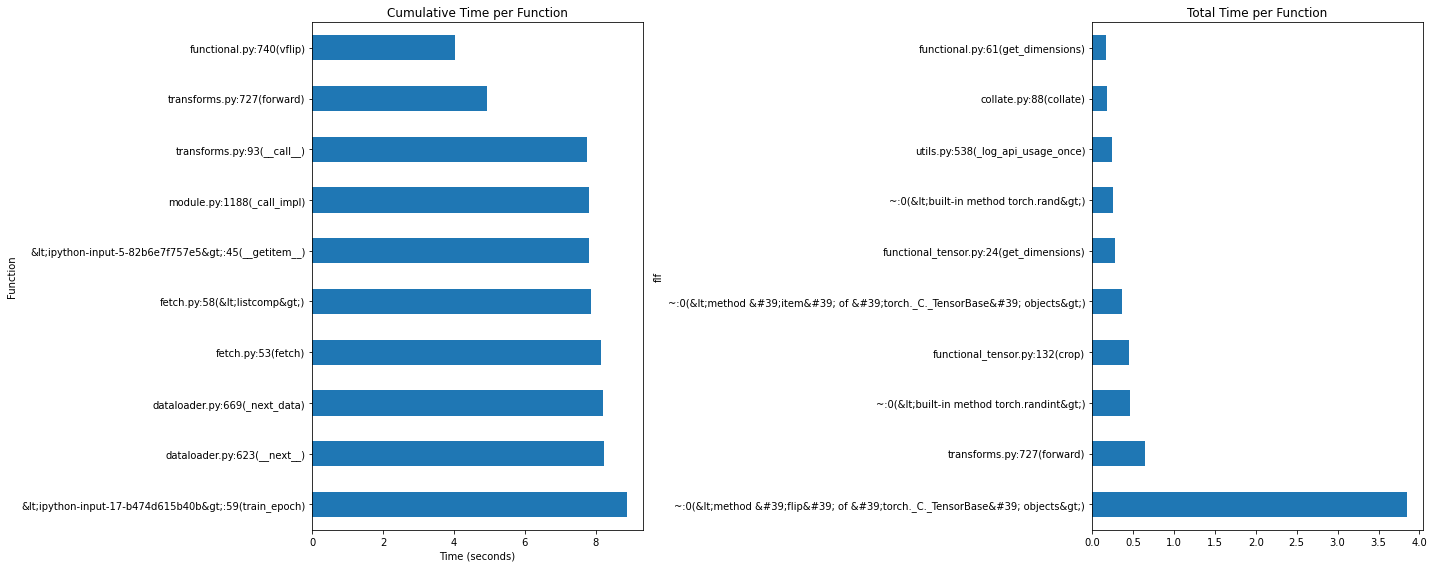

End of testing. Test accuracy 37.76%
Epoch 16
Train (step: 10/98)- (avg) loss: 1.6029 (avg) acc: 38.19%


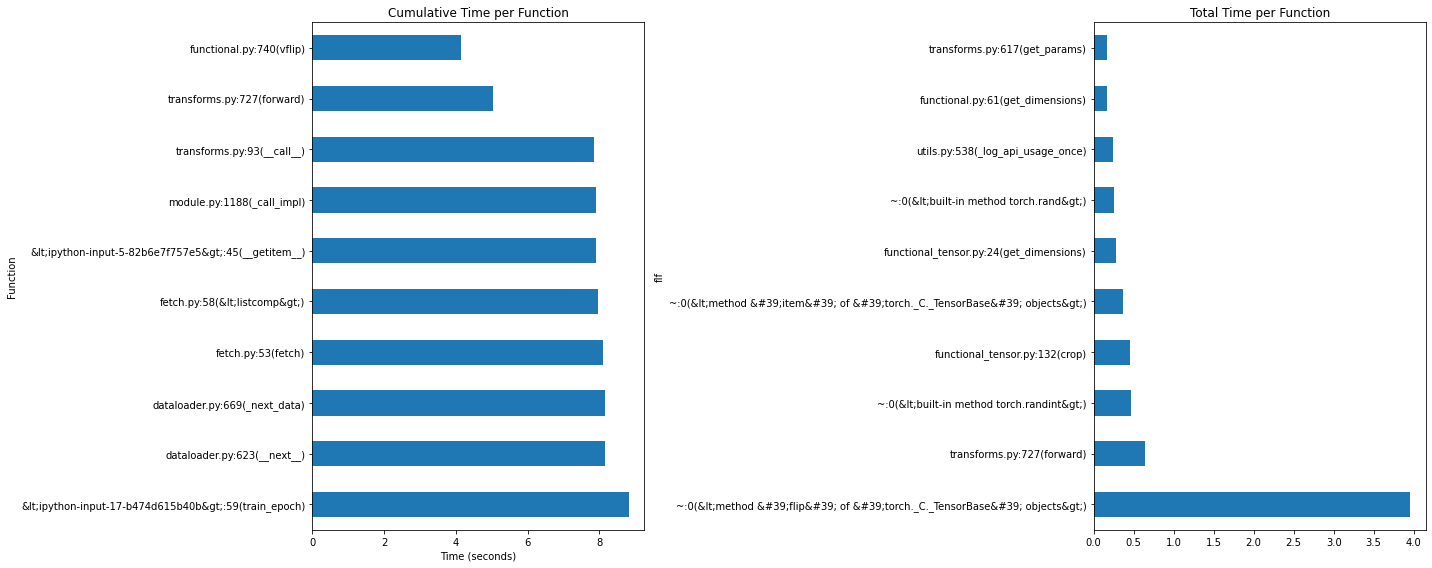

End of testing. Test accuracy 36.19%
Epoch 17
Train (step: 10/98)- (avg) loss: 1.5845 (avg) acc: 38.73%


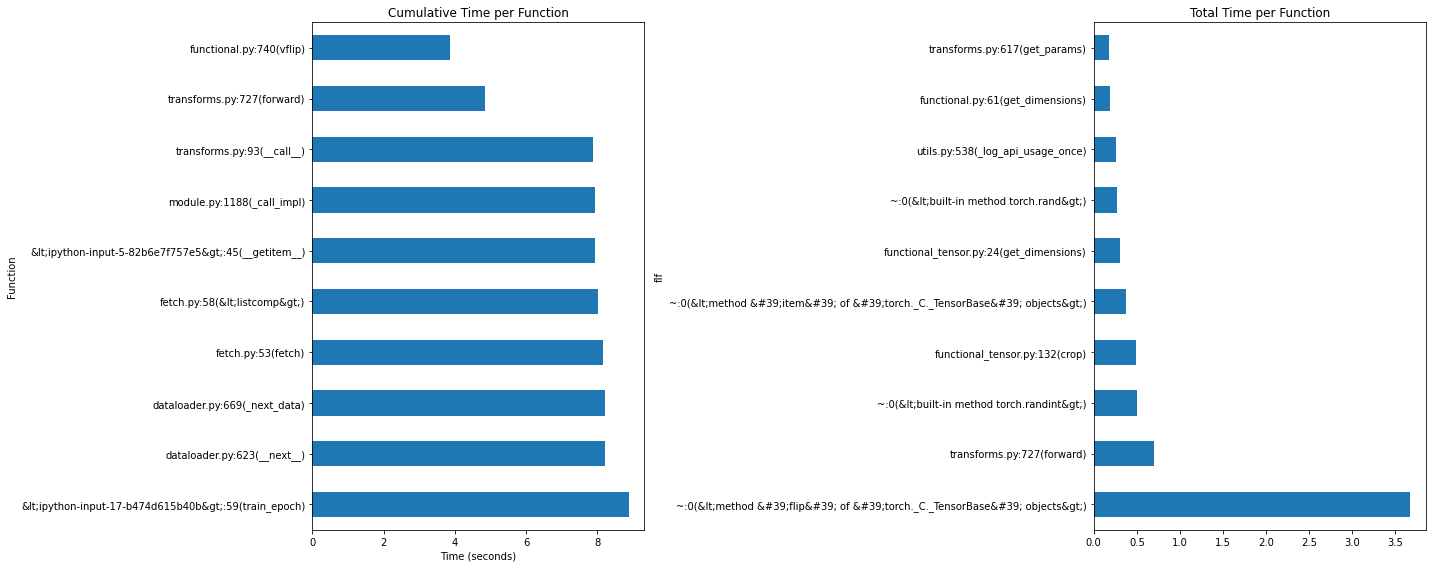

End of testing. Test accuracy 38.82%
Epoch 18
Train (step: 10/98)- (avg) loss: 1.5706 (avg) acc: 40.04%


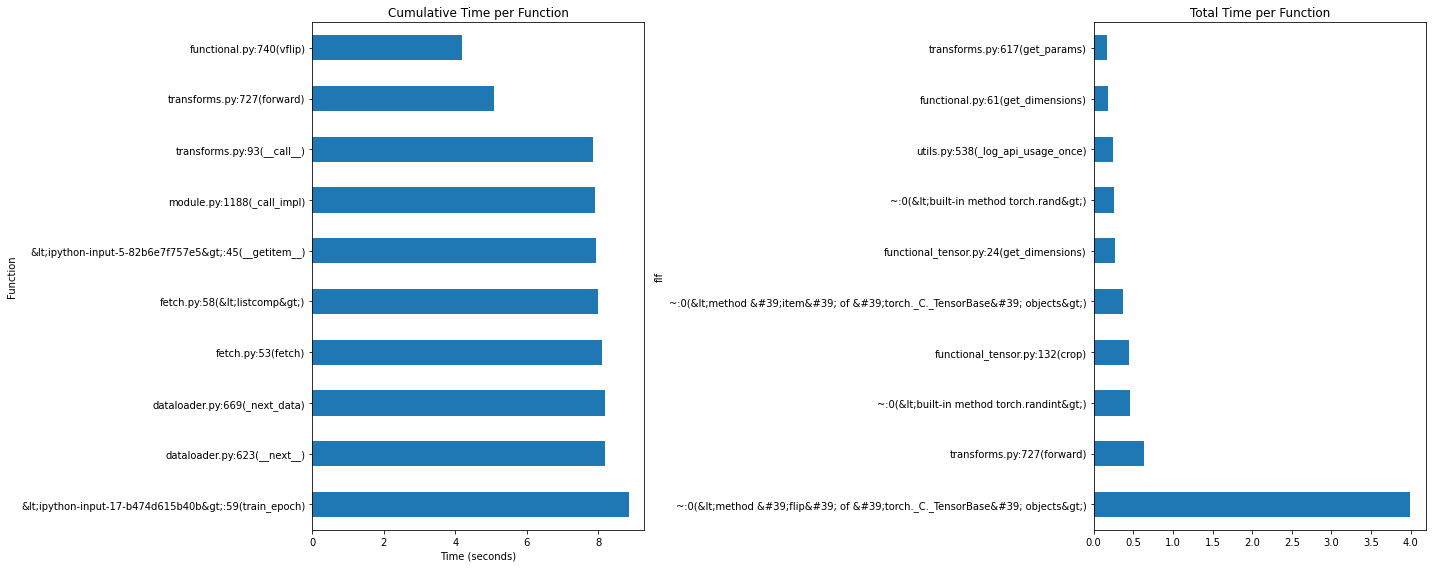

End of testing. Test accuracy 39.32%
Epoch 19
Train (step: 10/98)- (avg) loss: 1.5527 (avg) acc: 39.90%


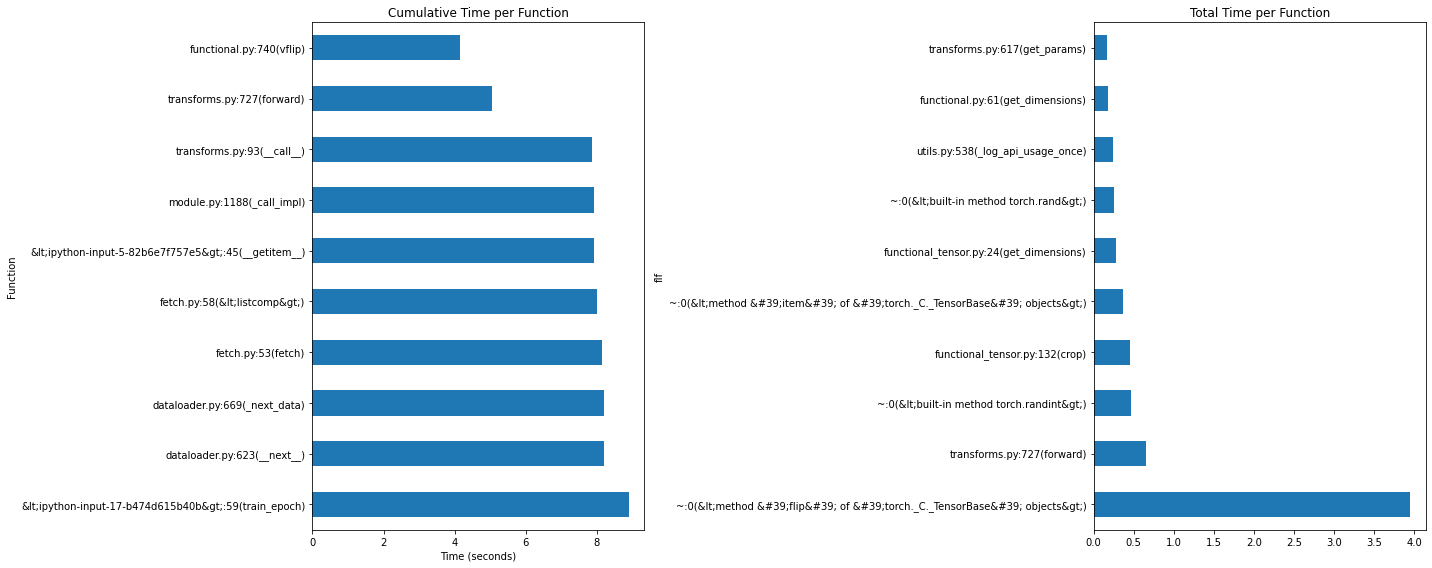

End of testing. Test accuracy 39.19%


In [ ]:
class ShortcutBlock(nn.Sequential):
  def __init__(self, c_in, c_out, kernel_size=1, stride: int = 1):

  
    projection = (stride != 1) or (c_in != c_out)
    super().__init__(OrderedDict([
              ('conv',  Conv(c_in, c_out, kernel_size=1, stride=stride, padding=1, bias=False)), 
            ('bn', BatchNorm(c_out)),
            ('relu', nn.ReLU(True))]
            if projection else [('id', Id())]))
          

net = DawnNet(Block=ShortcutBlock, prep_bn_relu=True).to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = SGDOptimizer(net.parameters(), weight_decay=5e-4*(BATCHSIZE := 512))
scheduler = PiecewiseLinearScheduler(optimizer, EPOCHS:=[0, 4, NUM_EPOCHS:=20], LR:=[0, 0.4, 0])

train_test(net, criterion, optimizer, scheduler, transformed_dataset["train"], transformed_dataset["eval"], NUM_EPOCHS, BATCHSIZE, num_workers=0)

In [ ]:
class ShortcutBlock(nn.Sequential):
  def __init__(self, c_in, c_out, kernel_size=1, stride: int = 1):

  
    projection = (stride != 1) or (c_in != c_out)
    super().__init__(OrderedDict([
              ('conv',  Conv(c_in, c_out, kernel_size=1, stride=stride, padding=1, bias=False)), 
            ('bn', BatchNorm(c_out)),
            ('relu', nn.ReLU(True)),
            ('pool', nn.MaxPool2d(2) )]
            if projection else [('id', Id())]))
          

net = DawnNet(Block=ShortcutBlock, prep_bn_relu=True).to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = SGDOptimizer(net.parameters(), weight_decay=5e-4*(BATCHSIZE := 512))
scheduler = PiecewiseLinearScheduler(optimizer, EPOCHS:=[0, 4, NUM_EPOCHS:=20], LR:=[0, 0.4, 0])

train_test(net, criterion, optimizer, scheduler, transformed_dataset["train"], transformed_dataset["eval"], NUM_EPOCHS, BATCHSIZE, num_workers=0)

Epoch 0
Train (step: 10/98)- (avg) loss: 3.1746 (avg) acc: 10.09%


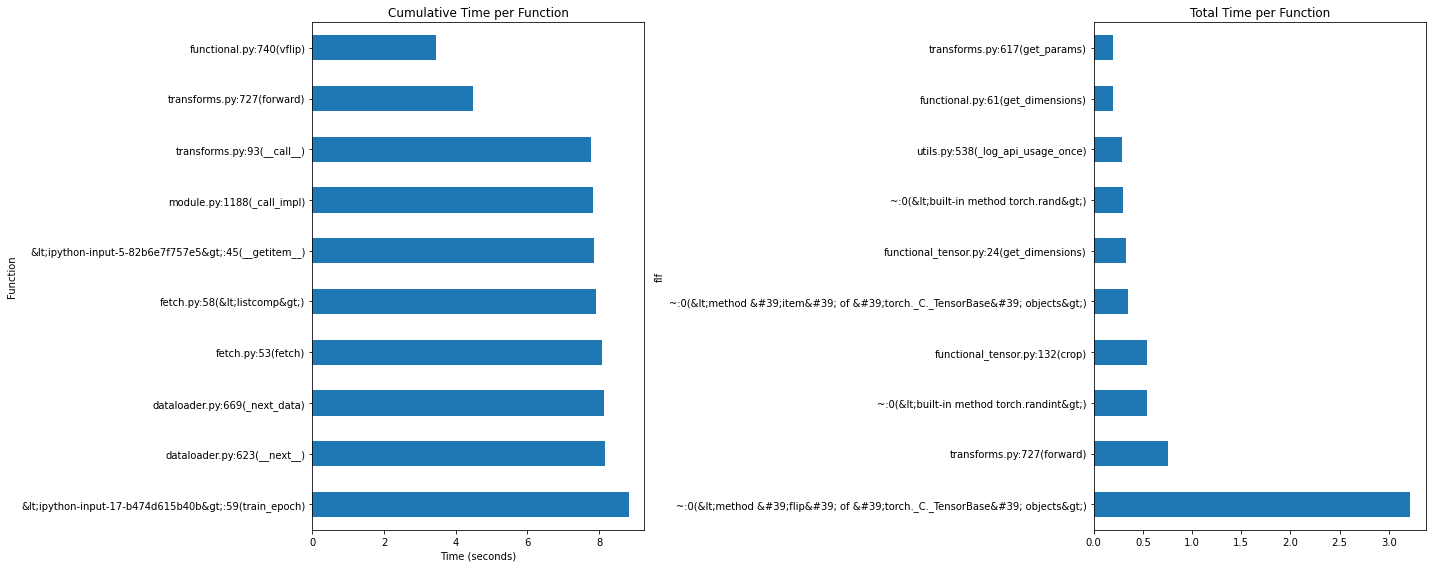

End of testing. Test accuracy 9.80%
Epoch 1
Train (step: 10/98)- (avg) loss: 22.7699 (avg) acc: 9.96%


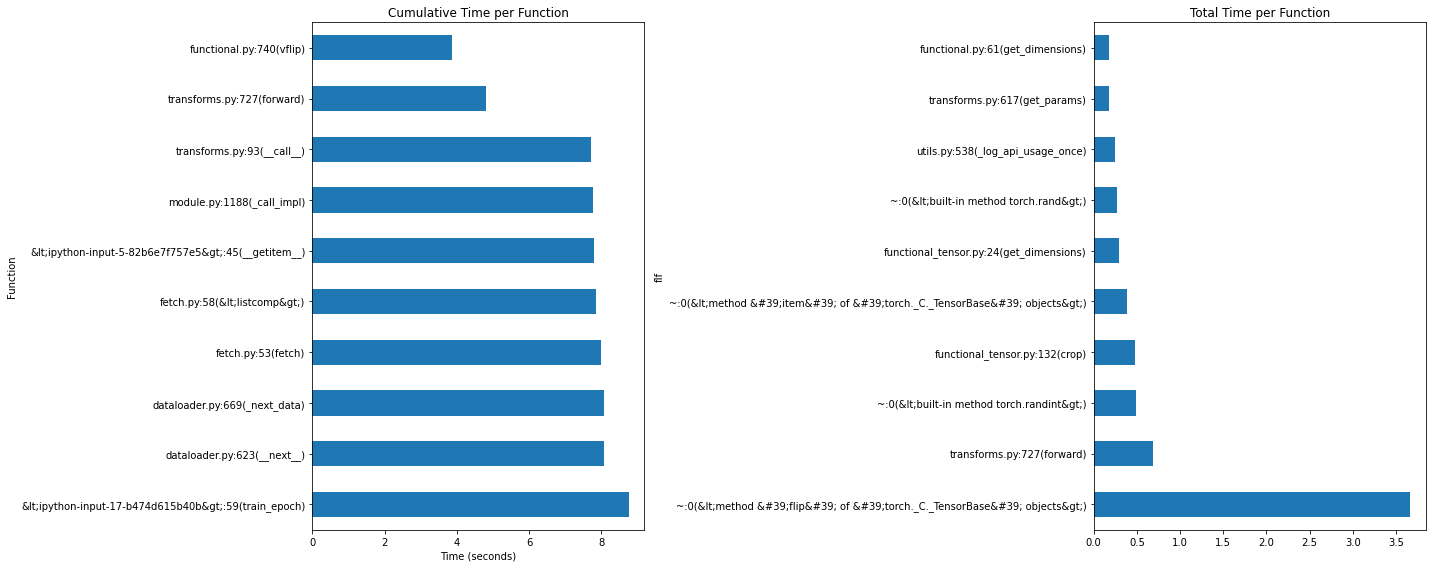

End of testing. Test accuracy 10.18%
Epoch 2
Train (step: 10/98)- (avg) loss: 2.3025 (avg) acc: 10.87%


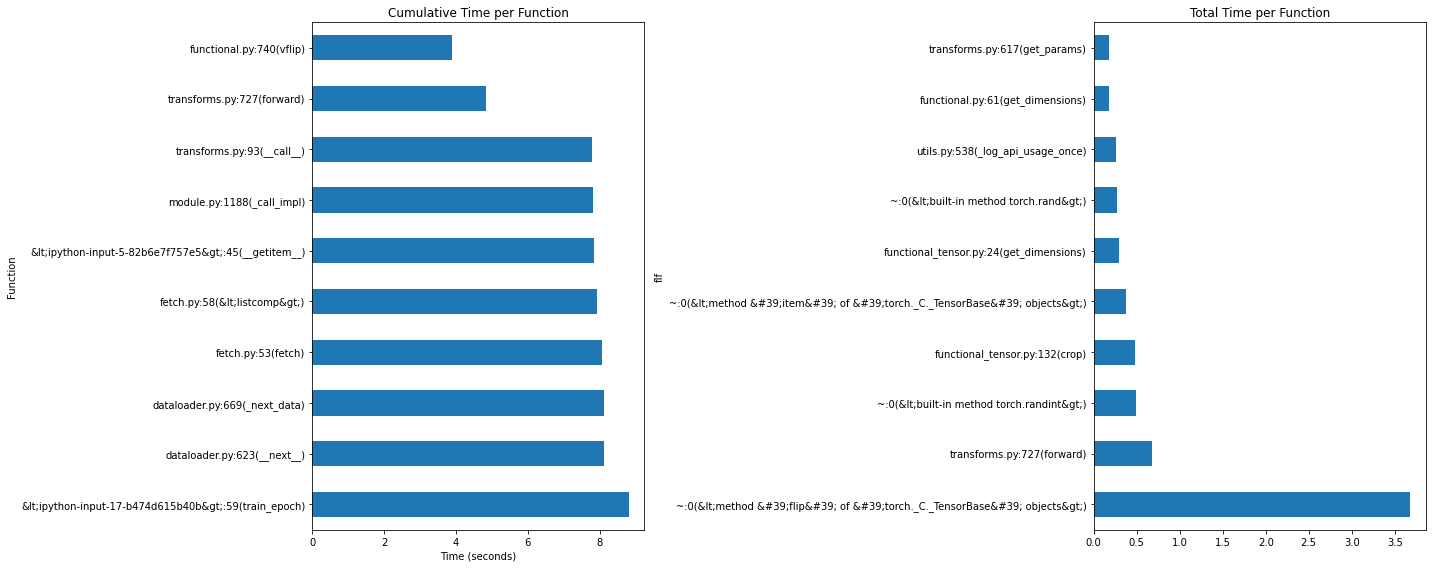

End of testing. Test accuracy 10.00%
Epoch 3
Train (step: 10/98)- (avg) loss: 2.3030 (avg) acc: 10.30%


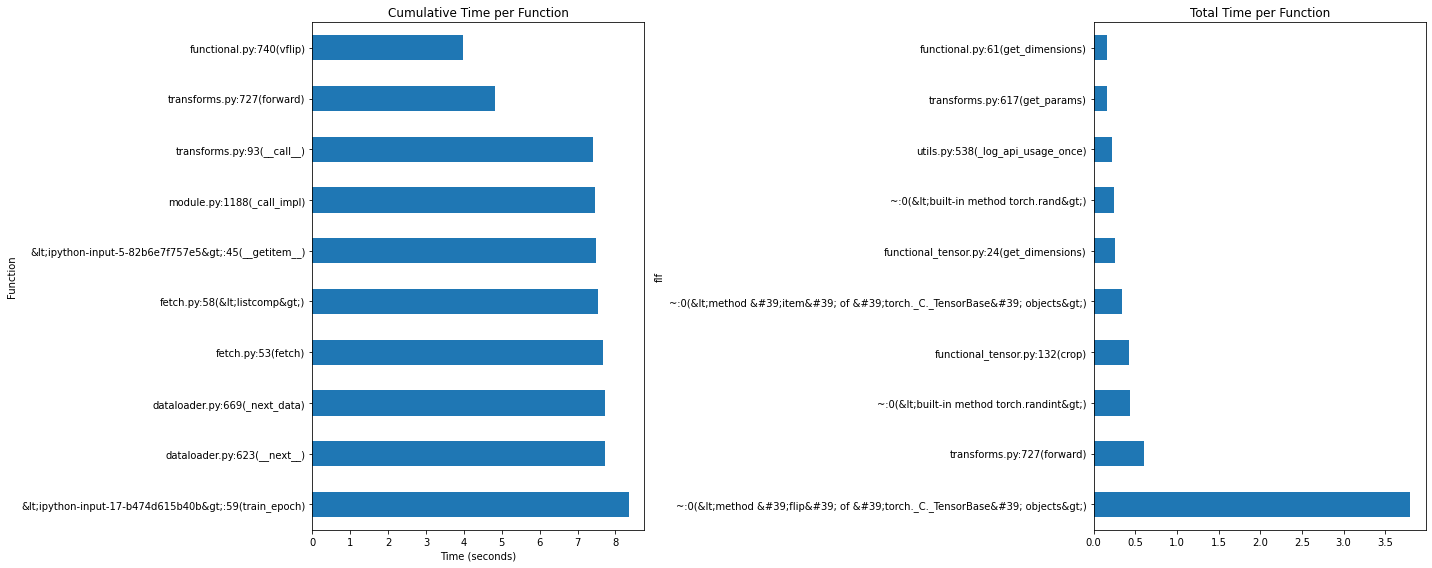

End of testing. Test accuracy 10.00%
Epoch 4
Train (step: 10/98)- (avg) loss: 2.3037 (avg) acc: 10.67%


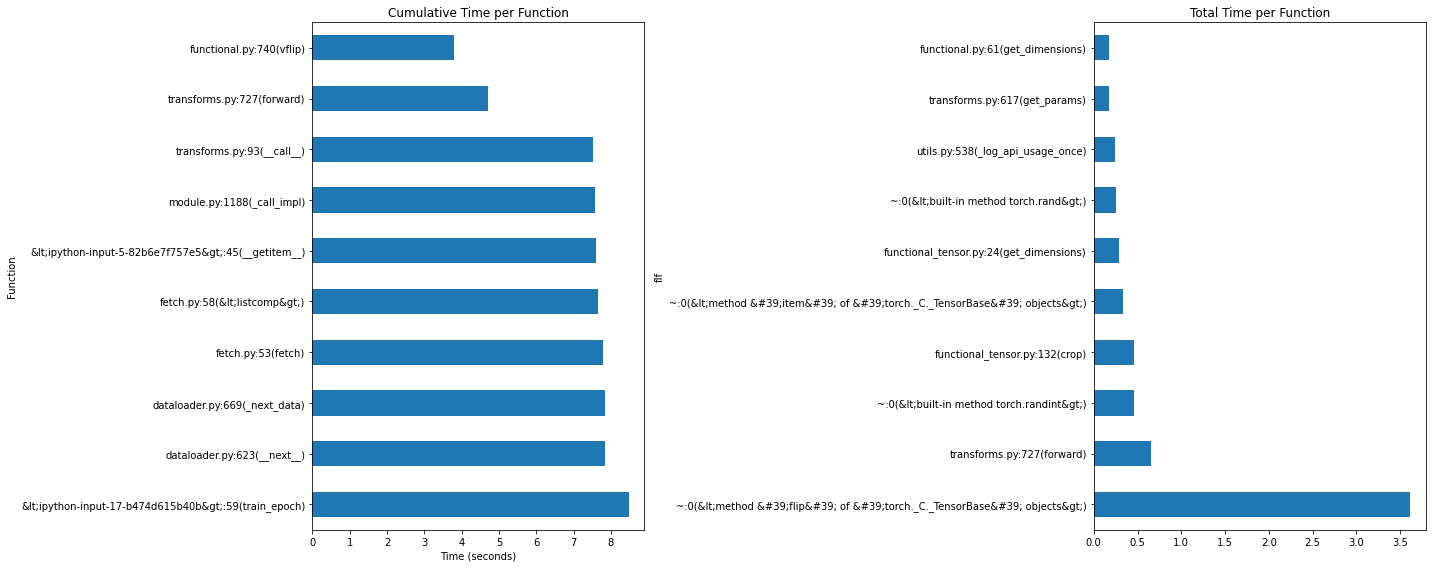

End of testing. Test accuracy 10.00%
Epoch 5
Train (step: 10/98)- (avg) loss: 2.3041 (avg) acc: 9.41%


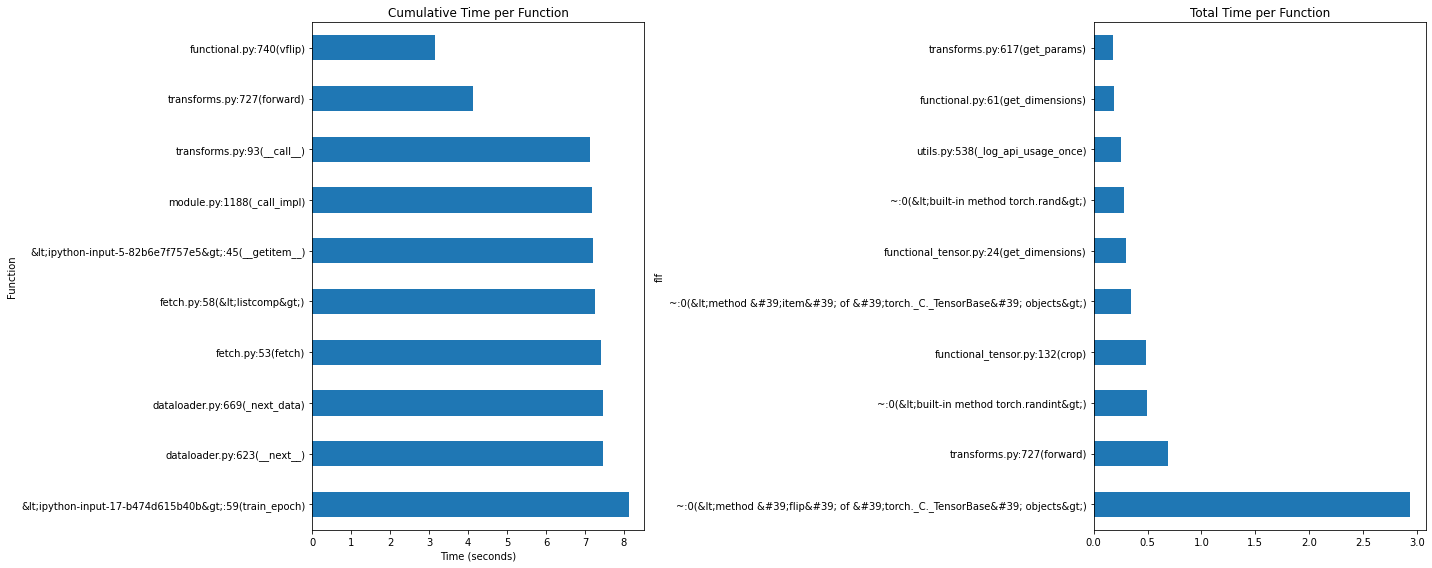

End of testing. Test accuracy 10.00%
Epoch 6
Train (step: 10/98)- (avg) loss: 2.3036 (avg) acc: 9.96%


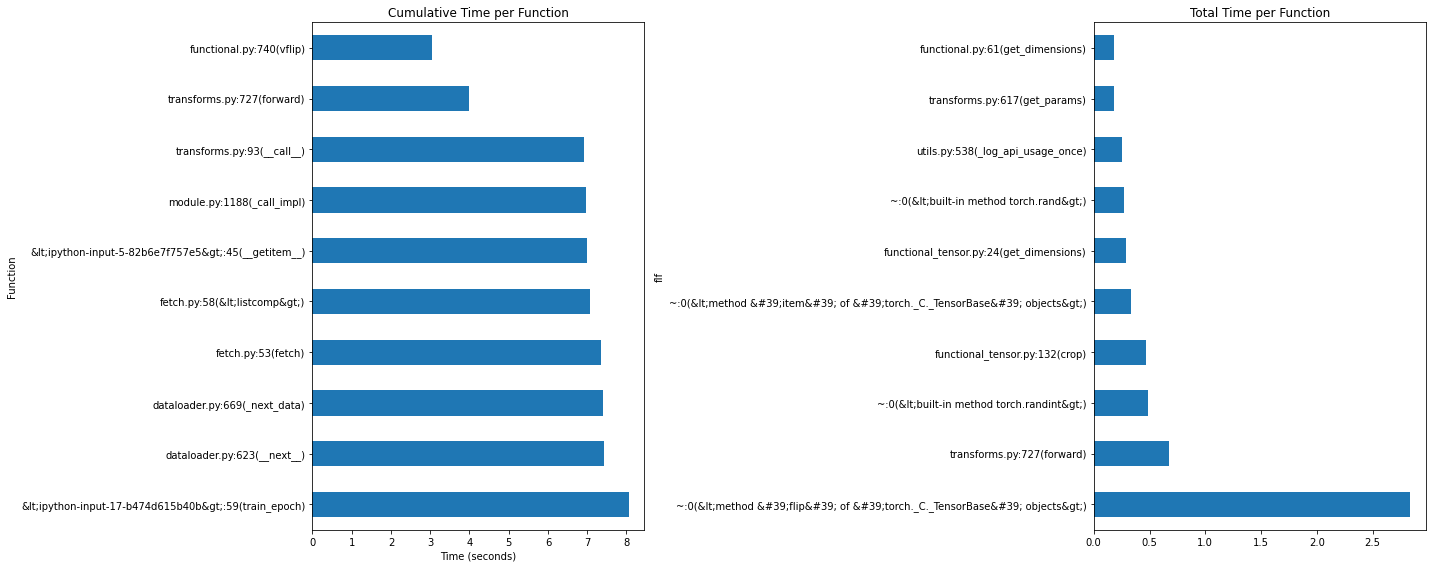

End of testing. Test accuracy 10.00%
Epoch 7
Train (step: 10/98)- (avg) loss: 2.3033 (avg) acc: 10.12%


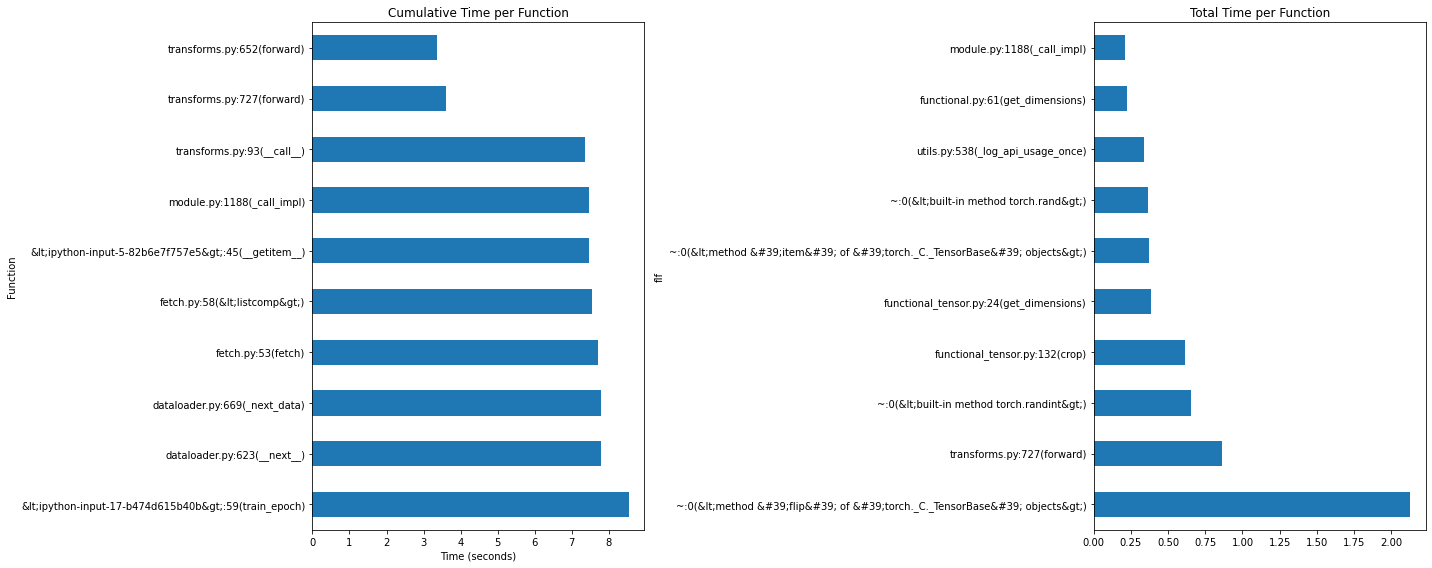

End of testing. Test accuracy 10.00%
Epoch 8
Train (step: 10/98)- (avg) loss: 2.3047 (avg) acc: 9.59%


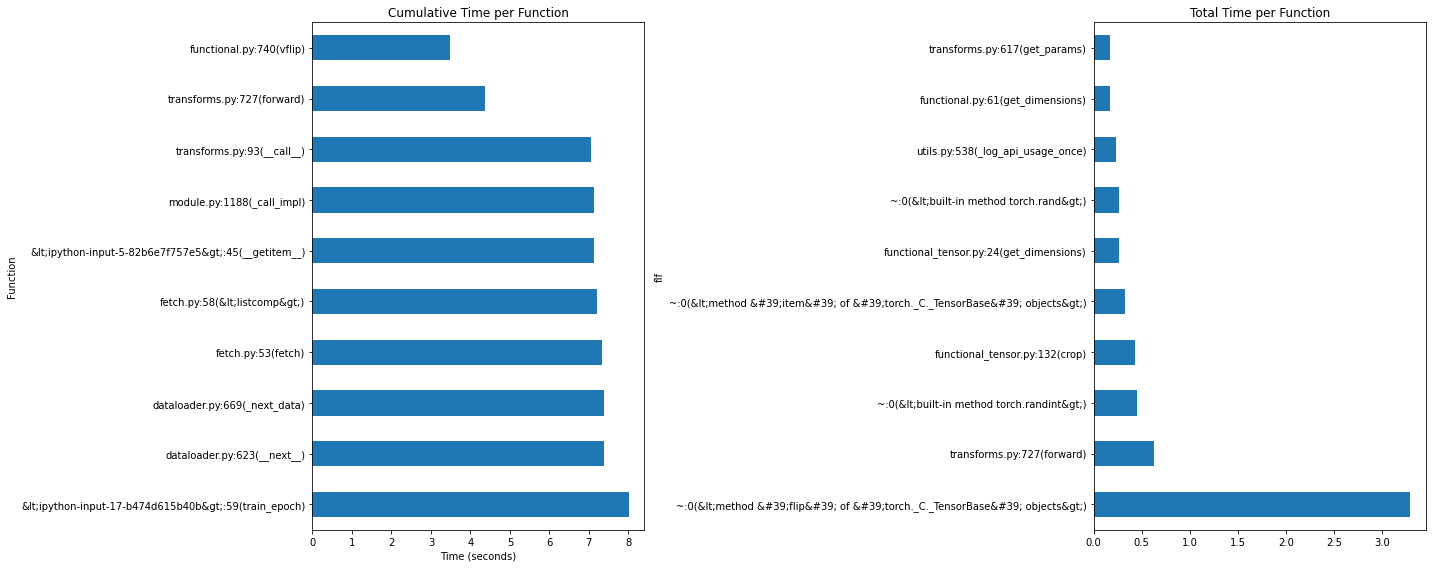

End of testing. Test accuracy 10.01%
Epoch 9
Train (step: 10/98)- (avg) loss: 2.3038 (avg) acc: 10.30%


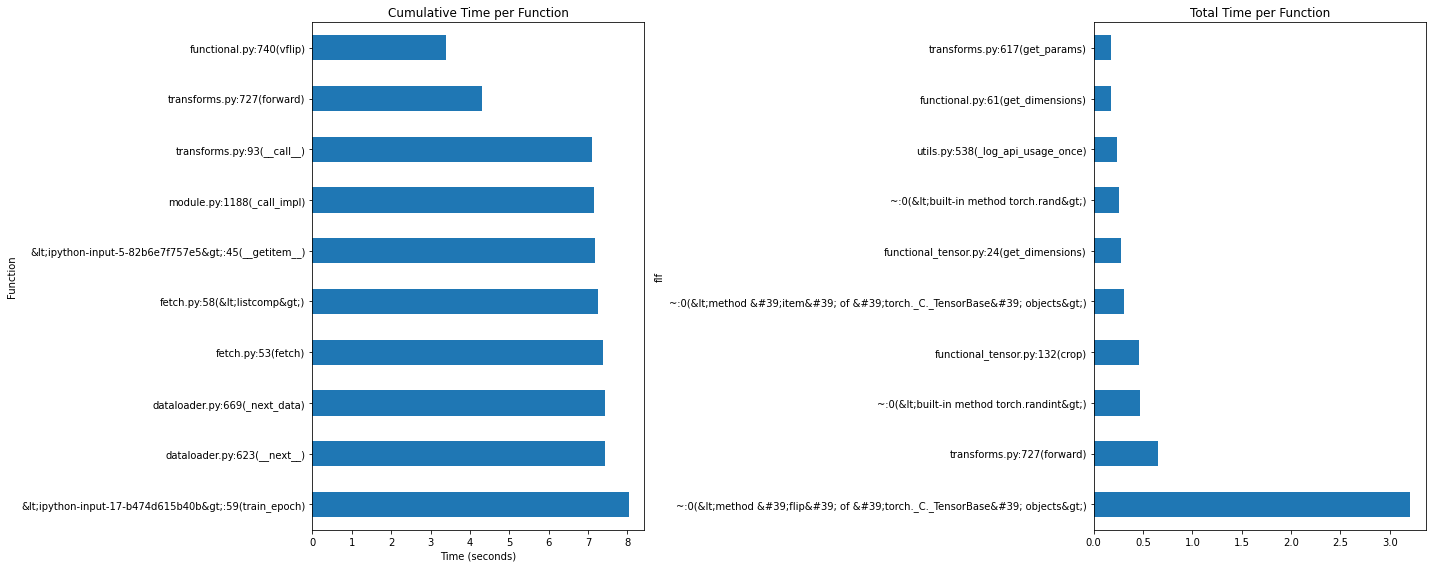

End of testing. Test accuracy 10.00%
Epoch 10
Train (step: 10/98)- (avg) loss: 2.3036 (avg) acc: 10.33%


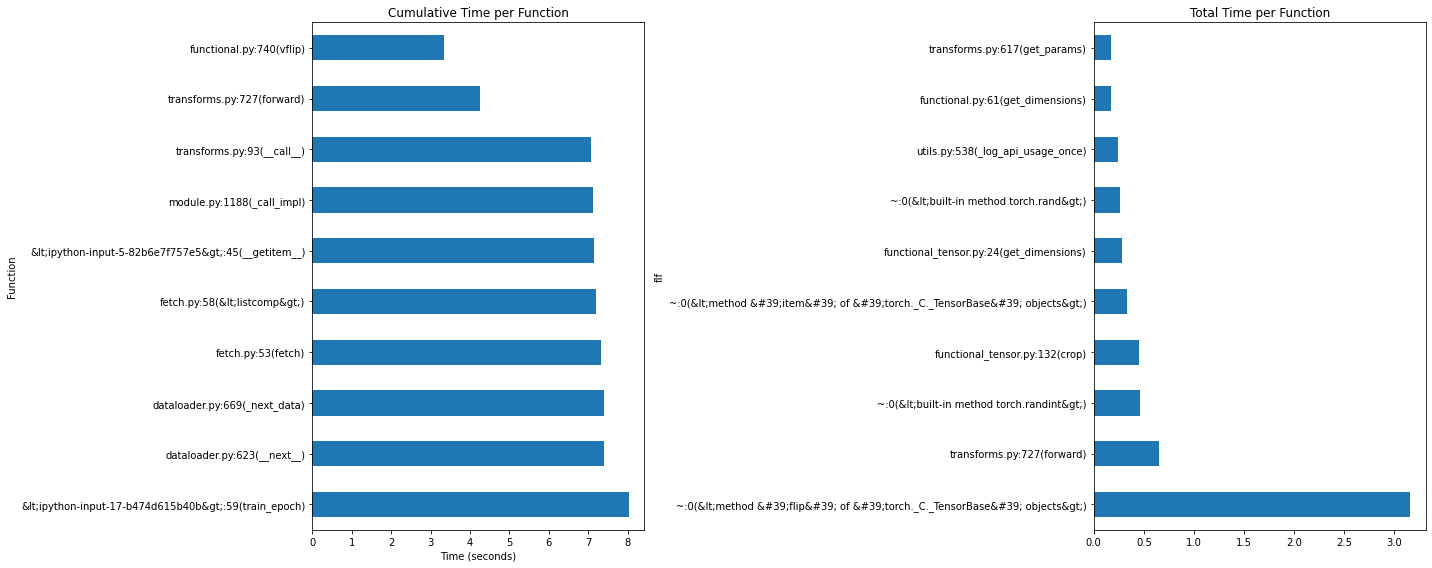

End of testing. Test accuracy 10.00%
Epoch 11
Train (step: 10/98)- (avg) loss: 2.3032 (avg) acc: 10.12%


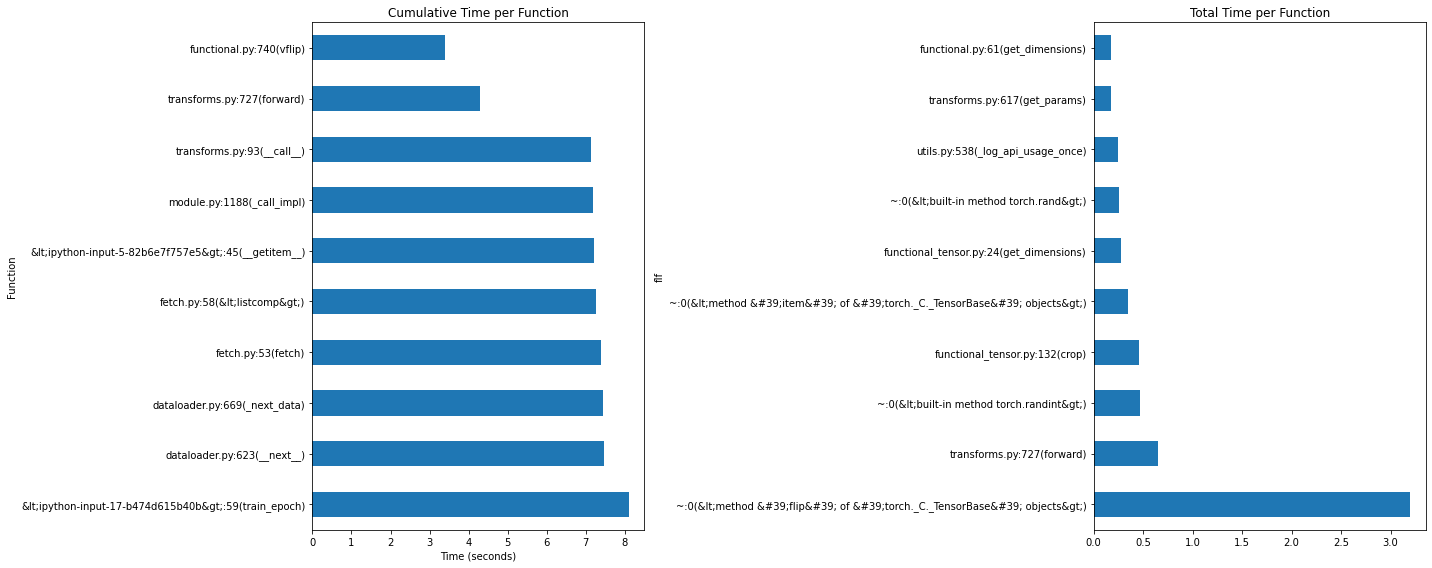

End of testing. Test accuracy 10.00%
Epoch 12
Train (step: 10/98)- (avg) loss: 2.3035 (avg) acc: 9.84%


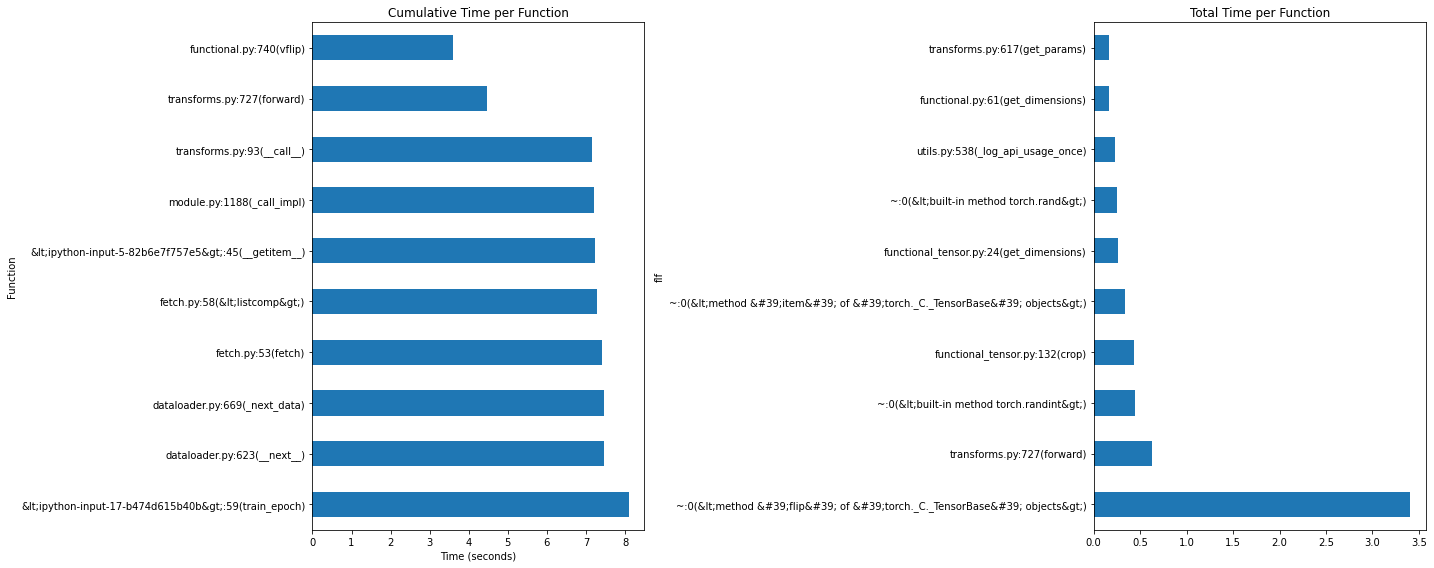

End of testing. Test accuracy 10.00%
Epoch 13
Train (step: 10/98)- (avg) loss: 2.3039 (avg) acc: 10.30%


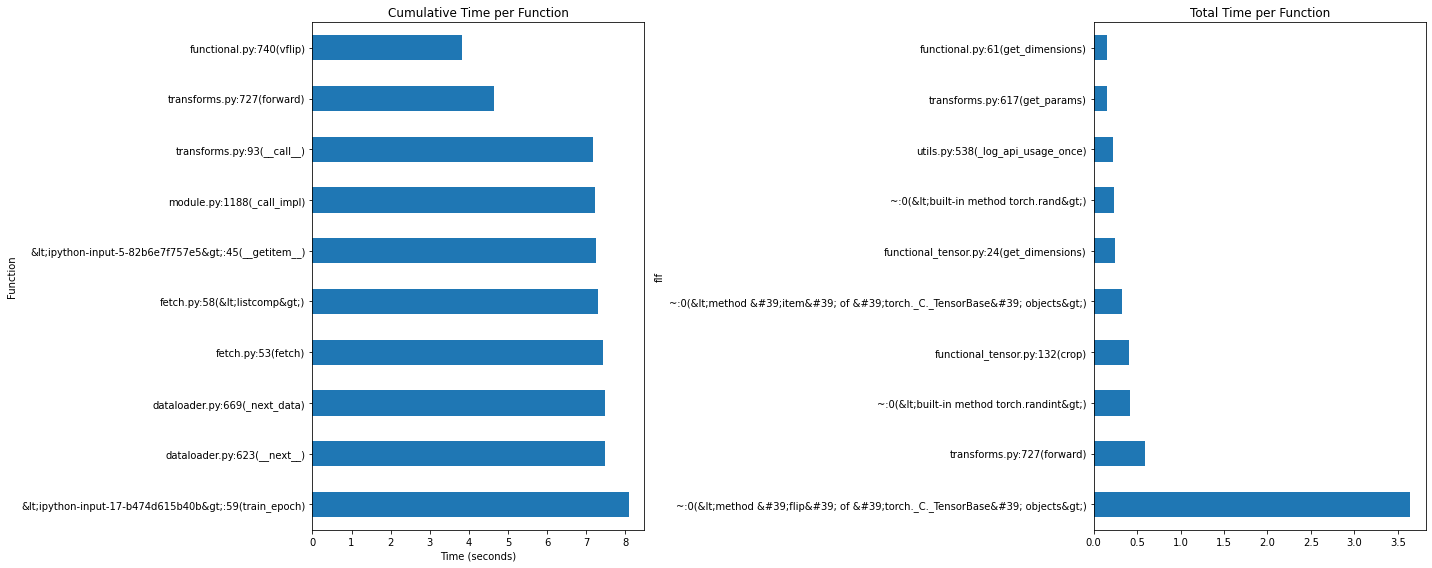

End of testing. Test accuracy 10.00%
Epoch 14
Train (step: 10/98)- (avg) loss: 2.3026 (avg) acc: 10.07%


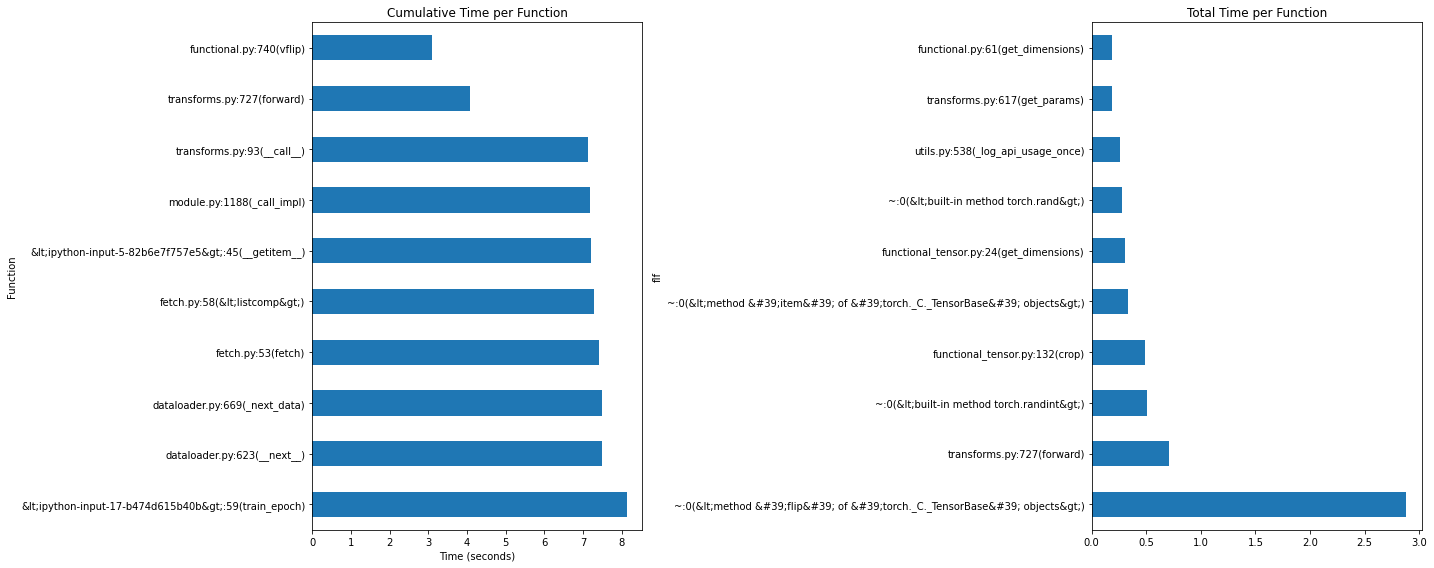

End of testing. Test accuracy 10.00%
Epoch 15
Train (step: 10/98)- (avg) loss: 2.3033 (avg) acc: 10.00%


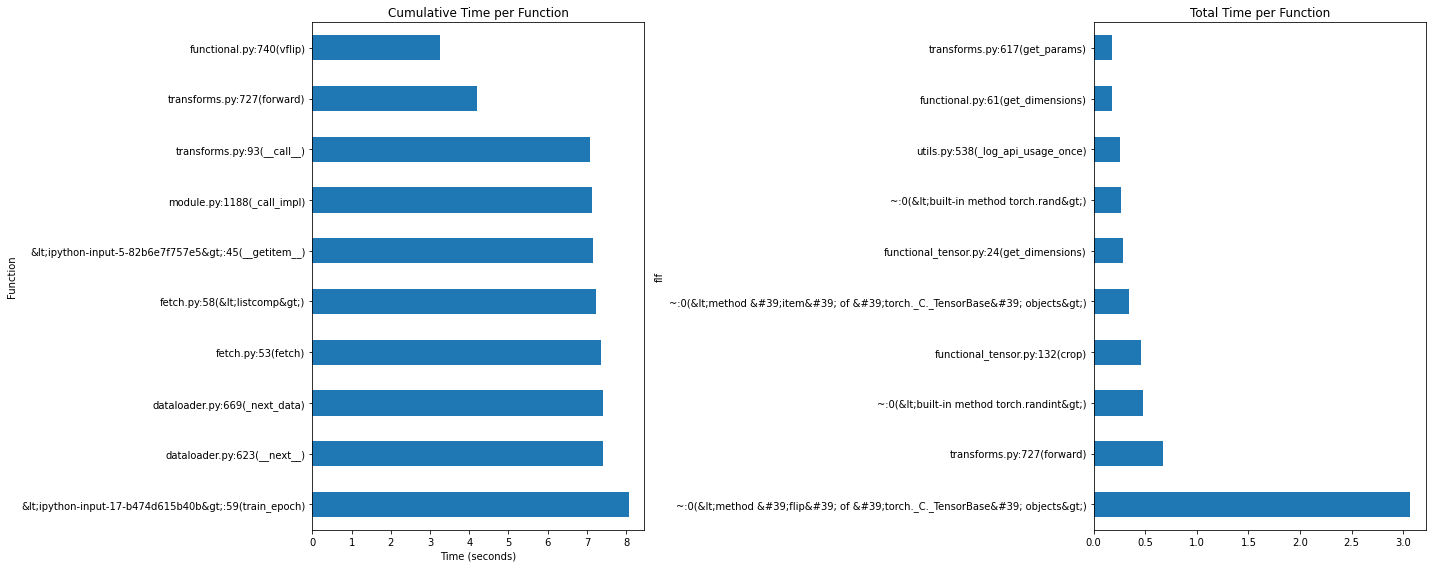

End of testing. Test accuracy 10.00%
Epoch 16
Train (step: 10/98)- (avg) loss: 2.3026 (avg) acc: 10.74%


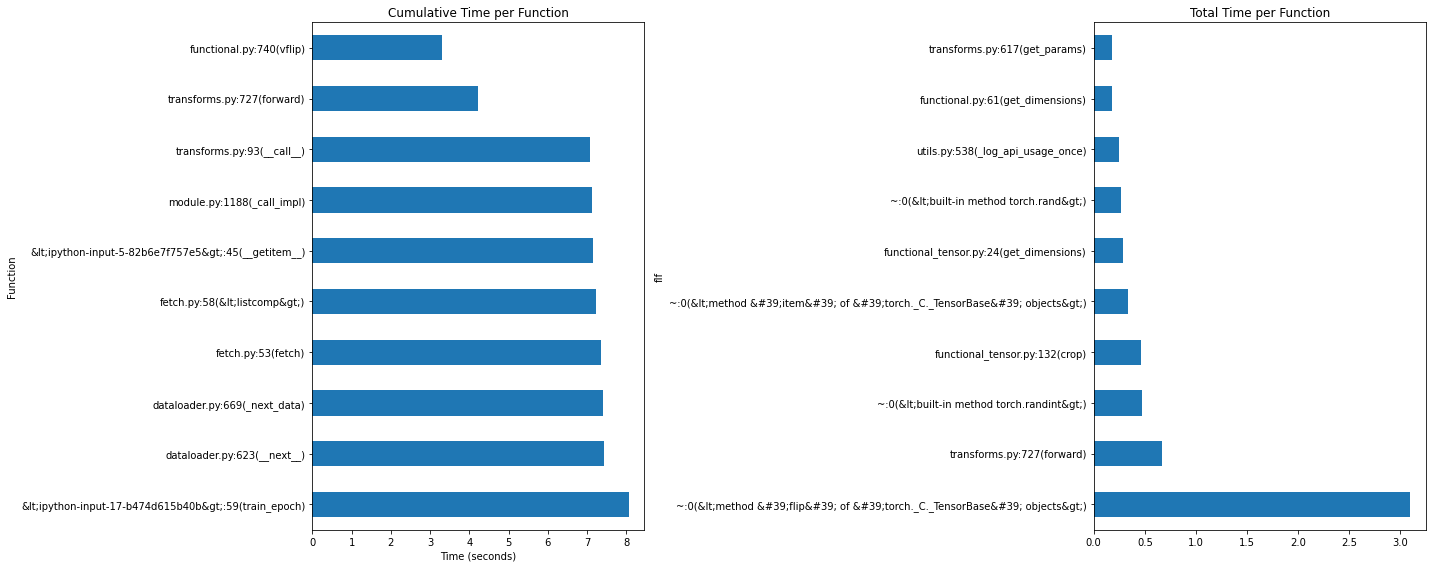

End of testing. Test accuracy 10.00%
Epoch 17
Train (step: 10/98)- (avg) loss: 2.3034 (avg) acc: 10.07%


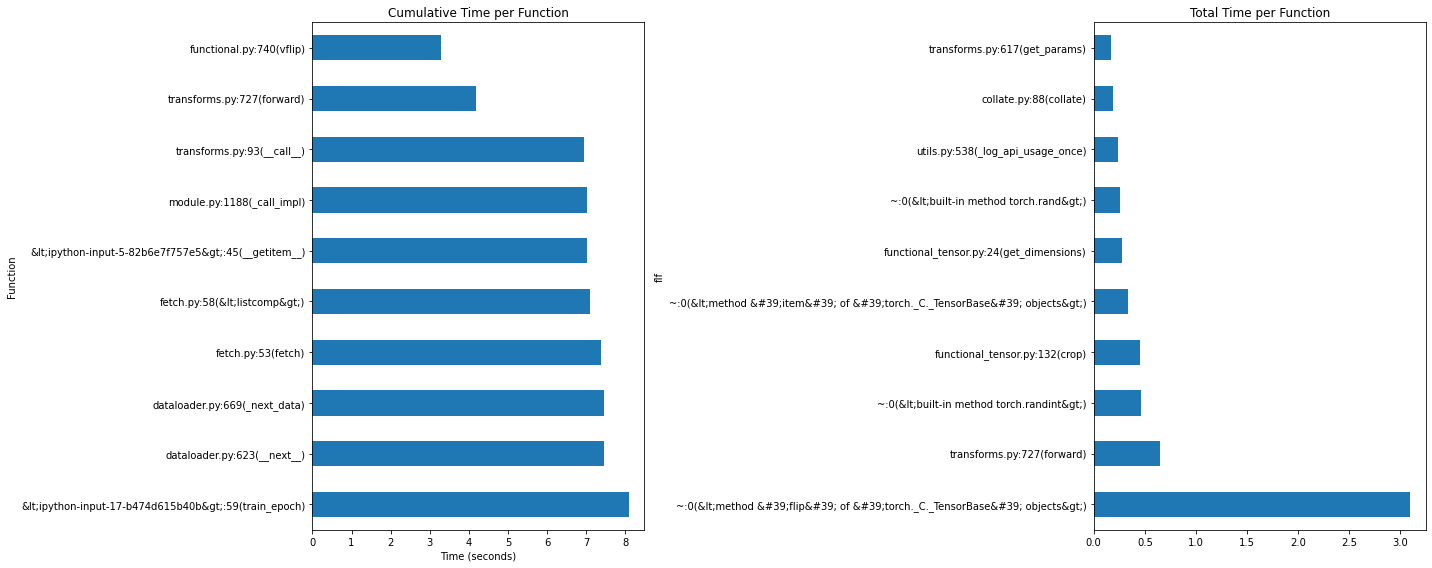

End of testing. Test accuracy 10.01%
Epoch 18
Train (step: 10/98)- (avg) loss: 2.3022 (avg) acc: 10.69%


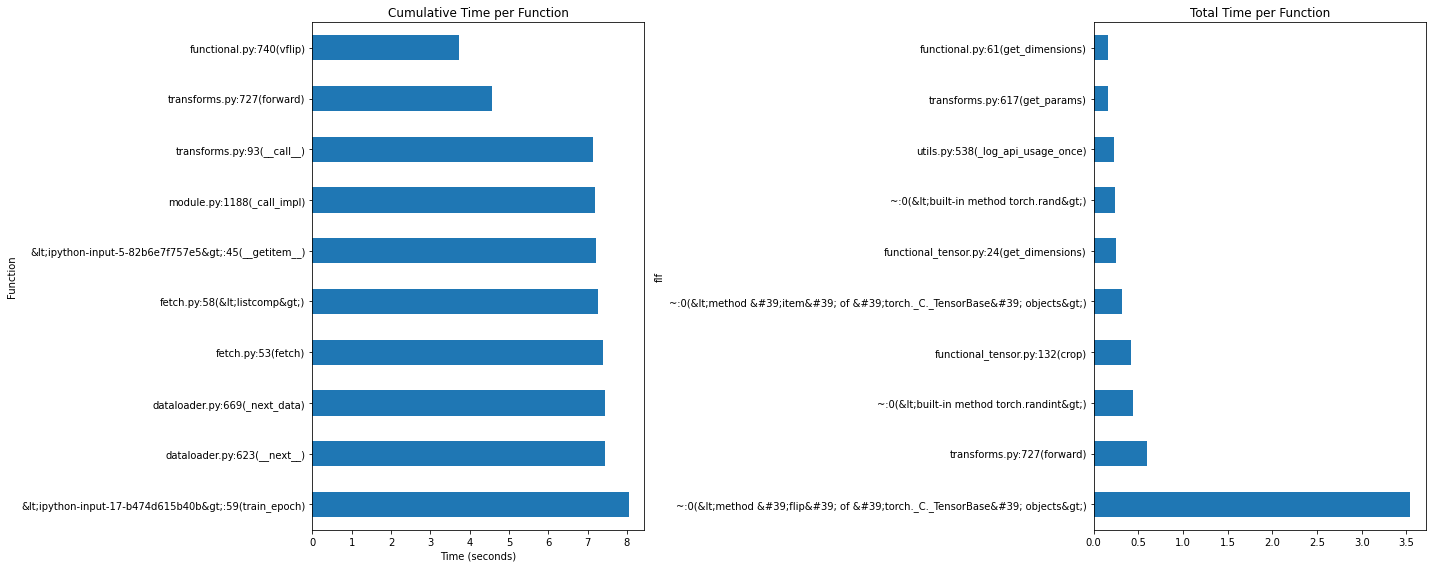

End of testing. Test accuracy 10.00%
Epoch 19
Train (step: 10/98)- (avg) loss: 2.3027 (avg) acc: 10.03%


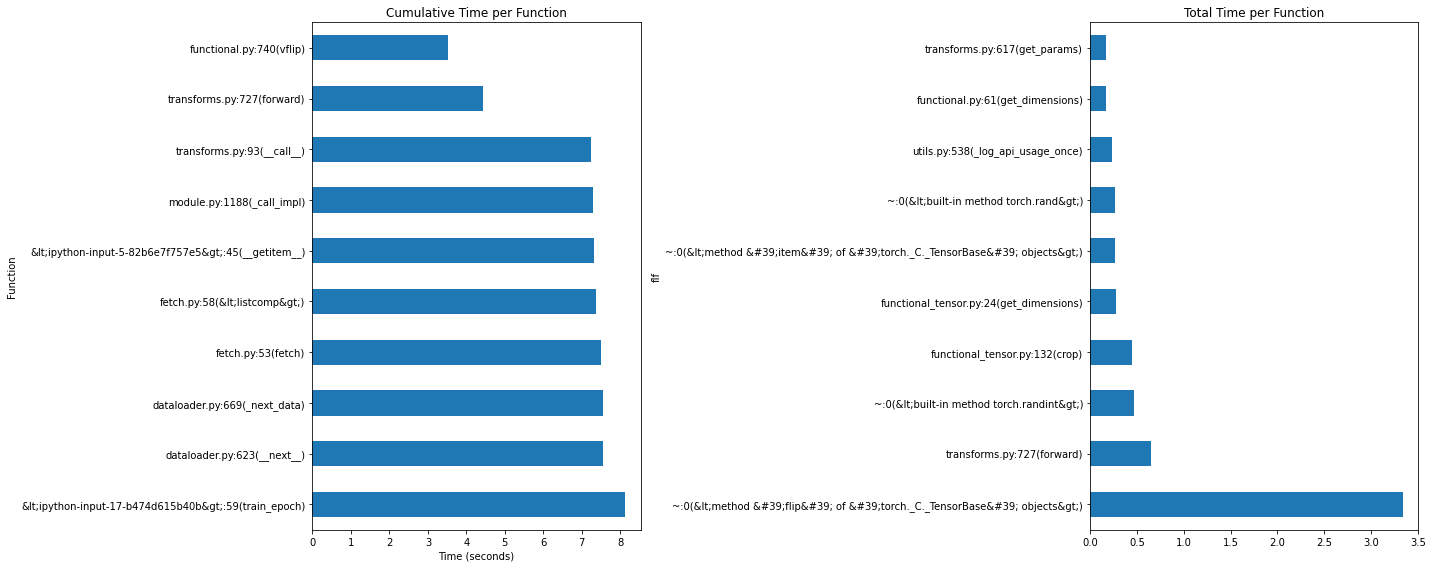

End of testing. Test accuracy 10.00%


In [ ]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': BatchNorm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Id()}



net = DawnNet(Block=ShortcutBlock, prep_bn_relu=True).to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = SGDOptimizer(net.parameters(), weight_decay=5e-4*(BATCHSIZE := 512))
scheduler = PiecewiseLinearScheduler(optimizer, EPOCHS:=[0, 4, NUM_EPOCHS:=20], LR:=[0, 0.4, 0])

train_test(net, criterion, optimizer, scheduler, transformed_dataset["train"], transformed_dataset["eval"], NUM_EPOCHS, BATCHSIZE, num_workers=0)